在工作区环境中install了`hflayers`，如果想在终端中运行，就得：
`conda activate /home/amax/Zixing_Jia/Vector-HASH-tinkering-main/.conda`

## Part 1: Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, randint
from tqdm import tqdm
import sys
import os

sys.path.append(os.path.abspath('.'))

from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
from src.seq_utils import nonlin

# Plotting style & Font Fix
try:
    plt.style.use('./src/presentation.mplstyle')
except:
    pass

import matplotlib
matplotlib.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.sans-serif": ["DejaVu Sans", "Arial"],
    "axes.unicode_minus": False
})

print("Imports successful!")

Imports successful!


## Part 1b: Hopfield Layer Setup for Place Cell Denoising
使用 `hflayers` 中的 Hopfield 层作为吸引子网络来去噪 p_pred。
- 实部和虚部分别使用独立的 Hopfield 层
- 训练时存储所有的 p_true 模式
- 推理时对 p_pred 进行去噪

In [2]:
import torch
import torch.nn as nn
from hflayers import Hopfield

def create_hopfield_retrieval(beta=100):
    """
    创建用于模式检索的 Hopfield 层。
    参考官方示例：pattern retrieval task - 不使用任何投影和归一化。
    
    Args:
        beta: scaling 参数，控制吸引子的锐度
    
    Returns:
        Hopfield 层实例
    """
    return Hopfield(
        scaling=beta,
        # 不投影输入（静态模式）
        state_pattern_as_static=True,
        stored_pattern_as_static=True,
        pattern_projection_as_static=True,
        # 不预处理输入（不归一化）
        normalize_stored_pattern=False,
        normalize_stored_pattern_affine=False,
        normalize_state_pattern=False,
        normalize_state_pattern_affine=False,
        normalize_pattern_projection=False,
        normalize_pattern_projection_affine=False,
        # 不后处理输出
        disable_out_projection=True
    )

class PlaceHopfieldDenoiser:
    """
    使用联合检索对 Place Cell 向量进行去噪。
    之前的实现对实部和虚部分别独立检索，可能检索到不同模式的实部和虚部！
    正确做法：将 [real, imag] 拼接成一个向量，进行联合检索，
    确保返回的是同一个存储模式的实部和虚部。
    
    工作流程：
    1. 训练阶段：收集 p_true 模式，存储为 concat([real, imag])
    2. 推理阶段：对 concat([p_real_pred, p_imag_pred]) 进行检索
    3. 返回检索到的模式的实部和虚部
    """
    
    def __init__(self, pattern_dim, beta=1.0, mode='nearest', 
                 device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Args:
            pattern_dim: Place cell 向量的维度 (Np)
            beta: Hopfield 层的 scaling 参数（仅 mode='hopfield' 时使用）
            mode: 'hopfield' 或 'nearest'（推荐）
            device: 计算设备
        """
        self.pattern_dim = pattern_dim
        self.beta = beta
        self.mode = mode
        self.device = device
        
        # ★ 存储拼接后的模式 [real, imag]，维度 2*Np
        self.stored_patterns_concat = []  # List of concat([real, imag])
        
        # 同时保留分开存储（用于返回结果）
        self.stored_patterns_real = []
        self.stored_patterns_imag = []
        
        # Hopfield 层（在 build() 后初始化）
        self.hopfield = None
        self.is_built = False
        
        print(f"PlaceHopfieldDenoiser initialized (JOINT retrieval):")
        print(f"  Pattern dim: {pattern_dim} (concat dim: {2*pattern_dim})")
        print(f"  Mode: {mode}")
        if mode == 'hopfield':
            print(f"  Beta (scaling): {beta}")
        print(f"  Device: {device}")
    
    def add_pattern(self, p_true_real, p_true_imag=None):
        """
        添加 p_true 模式。
        
        Args:
            p_true_real: 实部 (Np,) 或复数 (Np,)
            p_true_imag: 虚部 (Np,)，如果 p_true_real 是复数则忽略
        """
        p_true_real = np.asarray(p_true_real)
        
        # 处理复数输入
        if np.iscomplexobj(p_true_real):
            real_part = p_true_real.real.copy()
            imag_part = p_true_real.imag.copy()
        else:
            real_part = p_true_real.copy()
            imag_part = np.zeros_like(p_true_real) if p_true_imag is None else np.asarray(p_true_imag).copy()
        
        # 存储分开的实部和虚部（用于返回）
        self.stored_patterns_real.append(real_part)
        self.stored_patterns_imag.append(imag_part)
        
        # ★ 存储拼接后的向量（用于联合检索）
        concat_vec = np.concatenate([real_part, imag_part])
        self.stored_patterns_concat.append(concat_vec)
    
    def build(self):
        """构建去噪器"""
        if len(self.stored_patterns_concat) == 0:
            raise ValueError("No patterns stored. Call add_pattern() first.")
        
        num_patterns = len(self.stored_patterns_concat)
        
        # ★ 拼接后的模式矩阵 (num_patterns, 2*Np)
        self.Y_concat = torch.tensor(
            np.stack(self.stored_patterns_concat, axis=0),
            dtype=torch.float64,
            device=self.device
        )
        
        # 分开存储的矩阵（用于返回结果）
        self.Y_real = torch.tensor(
            np.stack(self.stored_patterns_real, axis=0),
            dtype=torch.float64,
            device=self.device
        )
        self.Y_imag = torch.tensor(
            np.stack(self.stored_patterns_imag, axis=0),
            dtype=torch.float64,
            device=self.device
        )
        
        # 预计算归一化（用于最近邻检索）
        self.Y_concat_norm = self.Y_concat / (torch.norm(self.Y_concat, dim=1, keepdim=True) + 1e-8)
        
        if self.mode == 'hopfield':
            self.hopfield = create_hopfield_retrieval(self.beta).to(self.device)
        
        self.is_built = True
        print(f"\n✓ Denoiser built with {num_patterns} patterns (JOINT retrieval)")
        print(f"  Concat pattern shape: ({num_patterns}, {2*self.pattern_dim})")
    
    def _denoise_nearest(self, p_real_pred, p_imag_pred, return_index=False):
        """
        使用**联合**最近邻检索。
        
        ★ 关键：将 [real, imag] 拼接，然后找最相似的完整模式，
        确保返回的实部和虚部来自同一个模式！
        """
        p_real = torch.tensor(p_real_pred, dtype=torch.float64, device=self.device)
        p_imag = torch.tensor(p_imag_pred, dtype=torch.float64, device=self.device)
        
        single_input = p_real.ndim == 1
        if single_input:
            p_real = p_real.unsqueeze(0)
            p_imag = p_imag.unsqueeze(0)
        
        batch_size = p_real.shape[0]
        
        # 拼接实部和虚部
        p_concat = torch.cat([p_real, p_imag], dim=1)  # (batch, 2*Np)
        
        # 归一化查询
        p_concat_norm = p_concat / (torch.norm(p_concat, dim=1, keepdim=True) + 1e-8)
        
        # 计算余弦相似度
        sim = p_concat_norm @ self.Y_concat_norm.T  # (batch, num_patterns)
        
        # 找到最相似的模式（单次检索！）
        best_idx = torch.argmax(sim, dim=1)  # (batch,)
        
        # 从同一个模式返回实部和虚部
        p_real_denoised = self.Y_real[best_idx]  # (batch, Np)
        p_imag_denoised = self.Y_imag[best_idx]  # (batch, Np) - 来自同一模式！
        
        # 转换回 numpy
        p_real_np = p_real_denoised.cpu().numpy()
        p_imag_np = p_imag_denoised.cpu().numpy()
        
        if single_input:
            p_real_np = p_real_np[0]
            p_imag_np = p_imag_np[0]
            best_idx = best_idx[0].item()
        else:
            best_idx = best_idx.cpu().numpy()
        
        if return_index:
            return p_real_np, p_imag_np, best_idx
        return p_real_np, p_imag_np
    
    def _denoise_hopfield(self, p_real_pred, p_imag_pred):
        """使用 Hopfield 层进行联合检索"""
        p_real = torch.tensor(p_real_pred, dtype=torch.float64, device=self.device)
        p_imag = torch.tensor(p_imag_pred, dtype=torch.float64, device=self.device)
        
        single_input = p_real.ndim == 1
        if single_input:
            p_real = p_real.unsqueeze(0)
            p_imag = p_imag.unsqueeze(0)
        
        batch_size = p_real.shape[0]
        
        # ★ 拼接
        p_concat = torch.cat([p_real, p_imag], dim=1)  # (batch, 2*Np)
        
        # Hopfield 输入格式
        Y_batch = self.Y_concat.unsqueeze(0).expand(batch_size, -1, -1)
        R = p_concat.unsqueeze(1)  # (batch, 1, 2*Np)
        
        with torch.no_grad():
            output = self.hopfield((Y_batch, R, Y_batch))  # (batch, 1, 2*Np)
        
        output = output.squeeze(1)  # (batch, 2*Np)
        
        # 分割回实部和虚部
        p_real_denoised = output[:, :self.pattern_dim]
        p_imag_denoised = output[:, self.pattern_dim:]
        
        p_real_np = p_real_denoised.cpu().numpy()
        p_imag_np = p_imag_denoised.cpu().numpy()
        
        if single_input:
            p_real_np = p_real_np[0]
            p_imag_np = p_imag_np[0]
        
        return p_real_np, p_imag_np
    
    def denoise(self, p_real_pred, p_imag_pred, return_complex=True):
        """
        对预测的 place cell 向量去噪。
        
        ★ 使用联合检索：确保返回的实部和虚部来自同一个存储模式！
        
        Args:
            p_real_pred: 预测的实部 (Np,) - 实数
            p_imag_pred: 预测的虚部 (Np,) - 实数
            return_complex: 是否返回复数
        
        Returns:
            去噪后的 place cell 向量
        """
        if not self.is_built:
            raise RuntimeError("Denoiser not built. Call build() first.")
        
        p_real_pred = np.asarray(p_real_pred)
        p_imag_pred = np.asarray(p_imag_pred)
        
        if self.mode == 'nearest':
            p_real_np, p_imag_np = self._denoise_nearest(p_real_pred, p_imag_pred)
        else:
            p_real_np, p_imag_np = self._denoise_hopfield(p_real_pred, p_imag_pred)
        
        if return_complex:
            return p_real_np + 1j * p_imag_np
        else:
            return p_real_np, p_imag_np
    
    def get_num_patterns(self):
        return len(self.stored_patterns_concat)
    
    def clear_patterns(self):
        """清除所有存储的模式"""
        self.stored_patterns_concat = []
        self.stored_patterns_real = []
        self.stored_patterns_imag = []
        self.is_built = False
        self.hopfield = None
    
    def diagnose(self, p_real_pred, p_imag_pred, p_true_complex, top_k=5):
        """
        诊断工具：分析检索是否正确。
        
        Args:
            p_real_pred, p_imag_pred: 预测值
            p_true_complex: 真实值（复数）
            top_k: 显示前 k 个最相似的模式
        """
        p_real = torch.tensor(p_real_pred, dtype=torch.float64, device=self.device)
        p_imag = torch.tensor(p_imag_pred, dtype=torch.float64, device=self.device)
        
        if p_real.ndim == 1:
            p_real = p_real.unsqueeze(0)
            p_imag = p_imag.unsqueeze(0)
        
        # 拼接
        p_concat = torch.cat([p_real, p_imag], dim=1)
        p_concat_norm = p_concat / (torch.norm(p_concat, dim=1, keepdim=True) + 1e-8)
        
        # 相似度
        sim = (p_concat_norm @ self.Y_concat_norm.T)[0].cpu().numpy()
        
        # 找到真实模式在存储中的索引
        p_true_concat = np.concatenate([p_true_complex.real, p_true_complex.imag])
        true_sims = []
        for i in range(len(self.stored_patterns_concat)):
            stored = self.stored_patterns_concat[i]
            cos_sim = np.dot(stored, p_true_concat) / (np.linalg.norm(stored) * np.linalg.norm(p_true_concat) + 1e-8)
            true_sims.append(cos_sim)
        true_idx = np.argmax(true_sims)
        
        print(f"\n=== Denoiser Diagnosis ===")
        print(f"Total stored patterns: {len(self.stored_patterns_concat)}")
        
        top_indices = np.argsort(sim)[-top_k:][::-1]
        print(f"\nTop-{top_k} most similar patterns to query:")
        for rank, idx in enumerate(top_indices):
            marker = " ★ TRUE" if idx == true_idx else ""
            print(f"  {rank+1}. Pattern {idx}: similarity = {sim[idx]:.4f}{marker}")
        
        retrieved_idx = top_indices[0]
        print(f"\nRetrieved pattern: {retrieved_idx}")
        print(f"True pattern index: {true_idx}")
        print(f"Correct retrieval: {'✓ YES' if retrieved_idx == true_idx else '✗ NO'}")
        
        if retrieved_idx != true_idx:
            print(f"\n⚠ MISMATCH: Retrieved pattern {retrieved_idx} instead of {true_idx}")
            print(f"  Similarity to retrieved: {sim[retrieved_idx]:.4f}")
            print(f"  Similarity to true:      {sim[true_idx]:.4f}")

# 测试 Hopfield 层
print("Testing hflayers import...")
test_hopfield = create_hopfield_retrieval(beta=1.0)
print("✓ hflayers imported successfully!")
del test_hopfield

print("\n=== PlaceHopfieldDenoiser (JOINT Retrieval) ===")
print("★ Key fix: Real and imaginary parts are retrieved JOINTLY")
print("  - Concat [real, imag] into single vector")
print("  - Single retrieval ensures same-pattern real/imag")
print("  - Avoids mismatched real/imag from different patterns!")


Testing hflayers import...
✓ hflayers imported successfully!

=== PlaceHopfieldDenoiser (JOINT Retrieval) ===
★ Key fix: Real and imaginary parts are retrieved JOINTLY
  - Concat [real, imag] into single vector
  - Single retrieval ensures same-pattern real/imag
  - Avoids mismatched real/imag from different patterns!


## Part 2: Hyperparameters and Basic Setup
- 超参数设置这里的随机种子是真的有用的
- 有几次在没有设置随机种子的情况下，竟然出现了生成的Wpg是极坏的矩阵，极大影响重建率

In [3]:
# === Grid System Parameters ===
nruns = 1
np.random.seed(36)  
Np = 342  # Number of place cells
lambdas = [3, 4, 5]  # Grid periods
Ng = np.sum(np.square(lambdas))  # Number of grid cells
Npos = np.prod(lambdas)  # Spatial positions per axis

print(f"Grid Size (Npos): {Npos} x {Npos} = {Npos*Npos}")
print(f"Number of Grid Cells (Ng): {Ng}")
print(f"Number of Place Cells (Np): {Np}")

# === Phase Parameters ===
nph = 10  # Number of phases to test
phis = np.linspace(0, 0.5*np.pi, nph)  # Phases from 0 to π/2
print(f"\nPhase configurations (nph={nph}): {phis}")

# === Sensory Parameters ===
Ns_demo = 512  # Sensory dimension
k_sparse = 60  # Sparsity in sensory vectors
C = 30  # Number of cause events
max_effects = 5  # Max effects per cause

print(f"Sensory dimension: {Ns_demo}")
print(f"Number of causes: {C}")
print(f"Max effects per cause: {max_effects}")

def relu(x, thresh=0):
    return x * (x > thresh)

Grid Size (Npos): 60 x 60 = 3600
Number of Grid Cells (Ng): 50
Number of Place Cells (Np): 342

Phase configurations (nph=10): [0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633]
Sensory dimension: 512
Number of causes: 30
Max effects per cause: 5


## Part 3: Generate Grid and Place Books

In [4]:
# Generate real-valued grid book (traditional)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook_flattened = gbook.reshape(Ng, Npos*Npos)

# Create module_gbooks and module_sizes for attractor dynamics
module_sizes = [lam**2 for lam in lambdas]  # [9, 16, 25] for lambdas=[3,4,5]
module_gbooks = []
start_idx = 0
for i, lam in enumerate(lambdas):
    end_idx = start_idx + lam**2
    # Reshape to 2D: (module_size, Npos*Npos) for nearest_neighbor compatibility
    gbook_mod = gbook[start_idx:end_idx].reshape(lam**2, Npos*Npos)
    module_gbooks.append(gbook_mod)
    start_idx = end_idx

print(f"gbook shape: {gbook.shape}")
print(f"gbook_flattened shape: {gbook_flattened.shape}")
print(f"module_sizes: {module_sizes}")
print(f"Number of modules: {len(module_gbooks)}")

# Generate Wpg (place to grid)
Wpg = randn(nruns, Np, Ng)
c = 0.10  # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

# Generate real-valued pbook from Wpg
thresh = 2.0
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)

print(f"pbook shape: {pbook.shape}")
print(f"pbook_flattened shape: {pbook_flattened.shape}")
print(f"Wpg shape: {Wpg.shape}")

gbook shape: (50, 60, 60)
gbook_flattened shape: (50, 3600)
module_sizes: [9, 16, 25]
Number of modules: 3
pbook shape: (1, 342, 60, 60)
pbook_flattened shape: (1, 342, 3600)
Wpg shape: (1, 342, 50)


## Part 4: Create Phased Grid and Place Books

In [5]:
# Use float32 / complex64 to cut memory
dtype_real = np.float64
dtype_complex = np.complex128

Wpg = Wpg.astype(dtype_real)
print(f"Wpg shape: {Wpg.shape}")
gbook = gbook.astype(dtype_real)
phis = phis.astype(dtype_real)

# Build phased grid book (Ng, Npos, Npos, nph)
gbook_phased = gbook[..., None] * np.exp(1j * phis)[None, None, None, :]
gbook_phased = gbook_phased.astype(dtype_complex)
gbook_phased_flattened = gbook_phased.reshape(Ng, Npos * Npos, nph)

print(f"gbook_phased shape: {gbook_phased.shape}")
print(f"gbook_phased_flattened shape: {gbook_phased_flattened.shape}")
print(f"gbook_phased dtype: {gbook_phased.dtype}")

# Build phased place book by directly adding phases to real-valued pbook
# Similar to gbook_phased construction: pbook * e^{i*phis}
pbook_phased = pbook[..., None] * np.exp(1j * phis)[None, None, None, None, :]
pbook_phased = pbook_phased.astype(dtype_complex)
pbook_phased_flattened = pbook_phased.reshape(nruns, Np, Npos * Npos, nph)

print(f"pbook_phased shape: {pbook_phased.shape}")
print(f"pbook_phased_flattened shape: {pbook_phased_flattened.shape}")
print(f"pbook_phased dtype: {pbook_phased.dtype}")

Wpg shape: (1, 342, 50)
gbook_phased shape: (50, 60, 60, 10)
gbook_phased_flattened shape: (50, 3600, 10)
gbook_phased dtype: complex128
pbook_phased shape: (1, 342, 60, 60, 10)
pbook_phased_flattened shape: (1, 342, 3600, 10)
pbook_phased dtype: complex128


## Part 5: Learn Wgp Matrix

In [6]:
# Learn Wgp: from place to grid (corrected)
# Wgp = gbook @ pbook^{-1}
pbook_flattened_pinv = np.linalg.pinv(pbook_flattened[0])
Wgp = gbook_flattened @ pbook_flattened_pinv

print(f"Wgp shape: {Wgp.shape}")
print(f"Wgp dtype: {Wgp.dtype}")
print(f"Wgp condition number: {np.linalg.cond(Wgp):.2e}")

# For phased version, we need to learn Wgp that works with complex phase
# Since phase is global, Wgp should work with any phased grid
print("\n✓ Wgp learned (real-valued, place-to-grid mapping)")

Wgp shape: (50, 342)
Wgp dtype: float64
Wgp condition number: 1.57e+16

✓ Wgp learned (real-valued, place-to-grid mapping)


## Test 1: Verify Complex Phase Preservation in Grid-Place-Grid Cycle

最关键的一个部分在于相位解耦。因为：
$$
 \text{nonlin}(\hat{W}_{pg} (| g\rangle e^{i\phi} ))\neq \text{nonlin}(\hat{W}_{pg} | g\rangle) e^{i\phi} 
$$

nonlin是显然会破坏线性算子的简洁性质的，但又是从Grid投射到Place的必要步骤（去除$<0$的值），所以我们在进行nonlin时，必须要先对$|p_{raw}\rangle e^{i\phi}=\hat{W}_{pg} (| g\rangle e^{i\phi} ) $ 取模后恢复成原始实数版的 $|p_{raw}\rangle $，然后再过非线性。

但是重点在于取模的这个步骤，会导致$|p_{raw}\rangle $变成一个全正的向量，这样其实nonlin就失去了意义。并且更有趣的一点在于因为$\hat{W}_{pg}$中有负矩阵元，致使 $|p_{raw}\rangle e^{i\phi}$的实部有负号，在使用`np.angle`的时候就会导致实际解出的相位为$\phi_{true} - \pi$，显然是把实部的负号吸收了。

In [7]:

print("="*70)
print("TEST 1: Complex Phase Preservation in Grid↔Place Transformations")
print("="*70)

# Select a test position
test_x, test_y = 10, 15
pos_idx = test_x * Npos + test_y
print(f"\nTest position: ({test_x}, {test_y}), flat index: {pos_idx}")
print(f"Testing phases: {phis}")

errors_gp = []  # Errors in grid->place transformation (via Wpg)
errors_pg_raw = []  # Errors in place->grid BEFORE attractor
errors_pg_attr = []  # Errors in place->grid AFTER attractor
errors_mag = []  # Errors between mag_out and original pbook magnitude

Wgp_complex = Wgp.astype(dtype_complex)

def phase_demodulate(z_complex, snap_to_phis=True):
    """
    Phase demodulation: extract signed real values and estimate global phase.
    
    For real vectors (all phases are 0 or ±π), directly returns the real part.
    Otherwise, corrects negative phases and estimates global phase using circular mean.
    """
    z_mag = np.abs(z_complex)
    z_phase = np.angle(z_complex)
    
    # 特殊情况：如果所有相位mod π都接近0（实数向量），直接返回实部
    # 实数的相位是0或±π，模π后都是0
    z_phase_mod_pi = np.abs(np.mod(z_phase + 1e-10, np.pi))  # 加小偏移避免浮点误差
    if np.all(z_phase_mod_pi < 1e-5):
        return z_complex.real.astype(dtype_real), 0.0
    
    # Step 1: 修正负相位
    z_phase_corr = z_phase.copy()
    mask = z_phase < 0
    z_signed = z_mag.copy()
    z_signed[mask] = -z_signed[mask]
    z_phase_corr[mask] += np.pi
    
    # Step 2: 用加权圆形均值估计全局相位
    weights = z_mag.flatten()
    z_phase_flat = z_phase_corr.flatten()
    
    # 圆形加权和
    phasor_sum = np.sum(weights * np.exp(1j * z_phase_flat))
    phi = np.angle(phasor_sum)
    if phi < 0:
        phi += np.pi
    
    # Wrap to [0, pi) then snap to nearest known phase if requested
    phi = np.mod(phi, np.pi)

    # 修复：如果phi接近π（超过3/4处），应该wrap到0
    if phi > 0.75 * np.pi:
       phi = 0.0
    if snap_to_phis and 'phis' in globals():
        phis_arr = np.asarray(phis)
        phis_mod = np.mod(phis_arr, np.pi)
        nearest_idx = int(np.argmin(np.abs(phis_mod - phi)))
        phi = float(phis_mod[nearest_idx])
    
    return z_signed.astype(dtype_real), phi

def module_wise_NN_2d_complex(gin, module_gbooks, module_sizes, phase_range=(0.0, np.pi/2)):
    """
    Complex-valued attractor with phase demodulation.
    
    Args:
        gin: complex array, shape (1, Ng, 1)
        module_gbooks: list of module codebooks
        module_sizes: list of module sizes
        phase_range: tuple (low, high), enforced global phase range
    Returns:
        g_out: complex array, shape (1, Ng, 1)
    """
    # Demodulate: extract signed real values and estimate phase
    gin_signed, phi_hat = phase_demodulate(gin)
    # Apply attractor on signed real values
    g_mag_clean = module_wise_NN_2d(gin_signed, module_gbooks, module_sizes)
    
    # Reconstruct with estimated global phase
    g_out = g_mag_clean.astype(dtype_complex) * np.exp(1j * phi_hat)
    return g_out

# ============================================================
# DIAGNOSTIC: Compare real vs complex pipeline
# ============================================================
print("\n" + "="*70)
print("DIAGNOSTIC: Real vs Complex Pipeline Comparison")
print("="*70)

# Get the REAL (no phase) versions
g_x_real = gbook_flattened[:, pos_idx]              # (Ng,) real - ground truth grid
p_x_real = pbook_flattened[0, :, pos_idx]           # (Np,) real - ground truth place

print(f"\n--- Ground Truth (Real, no phase) ---")
print(f"  g_x_real norm: {np.linalg.norm(g_x_real):.4f}")
print(f"  p_x_real norm: {np.linalg.norm(p_x_real):.4f}")

# Test 1: Real place -> Real grid via Wgp
g_from_p_real = Wgp @ p_x_real                      # (Ng,) real
print(f"g_from_p_real  shape: {g_from_p_real.shape}")
print(f"\n--- Real Pipeline: p_x_real -> Wgp -> g ---")
print(f"  g_from_p_real norm: {np.linalg.norm(g_from_p_real):.4f}")
print(f"  Error (g_from_p_real vs g_x_real): {np.linalg.norm(g_from_p_real - g_x_real):.4e}")

# Test 2: Real grid through attractor
gin_real = g_from_p_real[None, :, None]             # (1, Ng, 1) for module_wise_NN
g_attr_real = module_wise_NN_2d(gin_real, module_gbooks, module_sizes)[:, :, 0][0]
print(f"\n--- Real Pipeline: g_from_p_real -> Attractor -> g_attr ---")
print(f"  g_attr_real norm: {np.linalg.norm(g_attr_real):.4f}")
print(f"  Error (g_attr_real vs g_x_real): {np.linalg.norm(g_attr_real - g_x_real):.4e}")

# Test 3: Ground truth grid through attractor (should be 0 error)
gin_gt = g_x_real[None, :, None]
g_attr_gt = module_wise_NN_2d(gin_gt, module_gbooks, module_sizes)[:, :, 0][0]
print(f"\n--- Sanity Check: g_x_real (ground truth) -> Attractor ---")
print(f"  g_attr_gt norm: {np.linalg.norm(g_attr_gt):.4f}")
print(f"  Error (g_attr_gt vs g_x_real): {np.linalg.norm(g_attr_gt - g_x_real):.4e}")

print("\n" + "="*70)
print("Now testing with complex phases...")
print("="*70)

for phi_idx, phi in enumerate(phis):
    # === Step 1: Get phased grid vector ===
    g_x_phased = gbook_phased_flattened[:, pos_idx, phi_idx]  # (Ng,) complex
    
    # === Step 2: Grid -> Place via Wpg ===
    p_temp = Wpg[0] @ g_x_phased  # (Np,) complex
    
    # Demodulate to extract signed real values and estimated phase
    p_signed_real, phi_estimated = phase_demodulate(p_temp)
    
    # === DIAGNOSTIC 1: Compare p_signed_real with real pipeline (before nonlin) ===
    g_x_real_local = gbook_flattened[:, pos_idx]  # Real grid at this position
    p_pre_nonlin_real = Wpg[0] @ g_x_real_local  # Real pre-activation
    err_pre_nonlin = np.linalg.norm(p_signed_real - p_pre_nonlin_real)
    
    # Apply nonlinearity on signed real values
    mag_out = nonlin(p_signed_real, thresh=thresh)
    
    # Reconstruct with estimated phase
    p_x_from_wpg = mag_out.astype(dtype_complex) * np.exp(1j * phi_estimated)
    p_x_expected = pbook_phased_flattened[0, :, pos_idx, phi_idx]  # Expected result
    
    # Check error between mag_out and original pbook (without phase)
    p_x_original_real = pbook_flattened[0, :, pos_idx]     # Original real-valued pbook
    
    # 这个error=0说明相位解耦的操作没问题
    err_mag = np.linalg.norm(mag_out - p_x_original_real)
    errors_mag.append(err_mag)
    
    # Error in Wpg transformation (grid -> place)
    err_gp = np.linalg.norm(p_x_from_wpg - p_x_expected)
    errors_gp.append(err_gp)
    
    # === Step 3: Place -> Grid via Wgp (RAW, no attractor) ===
    g_x_raw = Wgp_complex @ p_x_from_wpg                   # (Ng,) complex
    
    # === DIAGNOSTIC 2: Compare g_x_raw demodulated with real pipeline ===
    g_x_raw_signed, phi_g_estimated = phase_demodulate(g_x_raw)
    g_from_p_real_local = Wgp @ p_x_original_real  # Real grid from real place
    err_g_raw_demod = np.linalg.norm(g_x_raw_signed - g_from_p_real_local)
    
    err_pg_raw = np.linalg.norm(g_x_raw - g_x_phased)
    errors_pg_raw.append(err_pg_raw)
    
    # === Step 4: Place -> Grid via Wgp + Attractor dynamics ===
    gin = g_x_raw[None, :, None]                           # (1, Ng, 1) for module_wise_NN
    g_x_attr = module_wise_NN_2d_complex(gin, module_gbooks, module_sizes)[:, :, 0][0]
    err_pg_attr = np.linalg.norm(g_x_attr - g_x_phased)
    errors_pg_attr.append(err_pg_attr)
    
    if phi_idx in [0,1,2]:
        print(f"\n{'='*70}")
        print(f"Phase φ = {phi:.4f} (index {phi_idx})")
        print(f"{'='*70}")
        print(f"\n--- Original Vectors ---")
        print(f"  |g_x⟩e^iφ norm: {np.linalg.norm(g_x_phased):.4f}")
        print(f"  |p_x⟩ (original, no phase) norm: {np.linalg.norm(p_x_original_real):.4f}")
        print(f"  mag_out norm: {np.linalg.norm(mag_out):.4f}")
        
        print(f"\n--- Phase Analysis ---")
        print(f"  True phase (phi): {phi:.6f} rad = {np.degrees(phi):.2f}°")
        print(f"  Estimated phase (phi_estimated): {phi_estimated:.6f} rad = {np.degrees(phi_estimated):.2f}°")
        print(f"  Phase error: {np.abs(phi_estimated - phi):.6e} rad")
        
        print(f"\n--- Error Statistics ---")
        print(f"  Error (p_signed_real vs p_pre_nonlin_real, before nonlin): {err_pre_nonlin:.4e}")
        print(f"  Error (mag_out vs original pbook, after nonlin): {err_mag:.4e}")
        print(f"  Error (Wpg, grid->place, after phase modulation): {err_gp:.4e}")
        print(f"  Error (g_x_raw demodulated vs real pipeline): {err_g_raw_demod:.4e}")
        print(f"  Error (Wgp RAW, place->grid): {err_pg_raw:.4e}")
        print(f"  Error (Wgp + Attractor): {err_pg_attr:.4e}")
        
        # === DIAGNOSTIC: Compare |g_x_raw| with real pipeline result ===
        g_x_raw_mag = np.abs(g_x_raw)                       # magnitude of complex g
        print(f"\n  --- DIAGNOSTIC (phi={phi:.1f}) ---")
        print(f"  |g_x_raw| (magnitude): {np.linalg.norm(g_x_raw_mag):.4f}")
        print(f"  g_from_p_real (real pipeline): {np.linalg.norm(g_from_p_real):.4f}")
        print(f"  Error (|g_x_raw| vs g_from_p_real): {np.linalg.norm(g_x_raw_mag - np.abs(g_from_p_real)):.4e}")
        
        # Compare attractor outputs
        g_x_attr_mag = np.abs(g_x_attr)
        print(f"  |g_x_attr| (magnitude after attractor): {np.linalg.norm(g_x_attr_mag):.4f}")
        print(f"  g_attr_real (real attractor): {np.linalg.norm(g_attr_real):.4f}")
        print(f"  Error (|g_x_attr| vs g_attr_real): {np.linalg.norm(g_x_attr_mag - g_attr_real):.4e}")

print(f"\n--- Error Statistics ---")
print(f"Mean error (mag_out vs original pbook): {np.mean(errors_mag):.4e}")
print(f"Mean error in Wpg transformation (grid->place): {np.mean(errors_gp):.4e}")
print(f"Mean error in Wgp RAW (place->grid): {np.mean(errors_pg_raw):.4e}")
print(f"Mean error in Wgp + Attractor: {np.mean(errors_pg_attr):.4e}")

if np.mean(errors_gp) < 0.1 and np.mean(errors_pg_attr) < 0.1:
    print("\n✓ TEST 1 PASSED: Phased transformations preserve phase correctly!")
else:
    print("\n✗ TEST 1 FAILED: High errors in phase preservation")

if np.mean(errors_pg_attr) < np.mean(errors_pg_raw):
    print(f"\n✓ Attractor reduces error by {(1 - np.mean(errors_pg_attr)/np.mean(errors_pg_raw))*100:.1f}%")
else:
    print("\n⚠ Attractor did not reduce error")

TEST 1: Complex Phase Preservation in Grid↔Place Transformations

Test position: (10, 15), flat index: 615
Testing phases: [0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633]

DIAGNOSTIC: Real vs Complex Pipeline Comparison

--- Ground Truth (Real, no phase) ---
  g_x_real norm: 1.7321
  p_x_real norm: 1.5917
g_from_p_real  shape: (50,)

--- Real Pipeline: p_x_real -> Wgp -> g ---
  g_from_p_real norm: 1.5430
  Error (g_from_p_real vs g_x_real): 5.0043e-01

--- Real Pipeline: g_from_p_real -> Attractor -> g_attr ---
  g_attr_real norm: 1.7321
  Error (g_attr_real vs g_x_real): 0.0000e+00

--- Sanity Check: g_x_real (ground truth) -> Attractor ---
  g_attr_gt norm: 1.7321
  Error (g_attr_gt vs g_x_real): 0.0000e+00

Now testing with complex phases...

Phase φ = 0.0000 (index 0)

--- Original Vectors ---
  |g_x⟩e^iφ norm: 1.7321
  |p_x⟩ (original, no phase) norm: 1.5917
  mag_out norm: 1.5917

--- Phase Analysis ---
  True phas

## Test 1b: Path Integration with Complex Phases

In [8]:
print("\n" + "="*70)
print("TEST 1b: Path Integration with Complex Phases")
print("="*70)

# Test path integration with phase
test_x, test_y = 5, 10
pos_idx = test_x * Npos + test_y
move_axis = 1  # Move along y-axis
move_direction = 1

# Load path integration matrix
Wgg = path_integration_Wgg_2d(lambdas, Ng, move_axis, move_direction)

print(f"\nStart position: ({test_x}, {test_y})")
print(f"Movement: axis={move_axis}, direction={move_direction}")
print(f"Expected next position: ({test_x}, {test_y + move_direction})")

errors_path_int = []

for phi_idx, phi in enumerate(phis[:3]):  # Test first 3 phases
    # Get initial phased grid state
    # gbook_phased_flattened shape: (Ng, Npos*Npos, nph)
    g_init = gbook_phased_flattened[:, pos_idx, phi_idx]  # (Ng,) complex
    
    # Apply path integration
    g_after_path = Wgg @ g_init  # Should give g_{x'} * e^{i*phi}
    
    # Get expected final grid state at next position
    next_pos_idx = (test_x) * Npos + (test_y + move_direction)
    g_expected = gbook_phased_flattened[:, next_pos_idx, phi_idx]  # (Ng,) complex
    
    err = np.linalg.norm(g_after_path - g_expected)
    errors_path_int.append(err)
    
    if phi_idx == 0:
        print(f"\nPhase φ = {phi:.4f}:")
        print(f"  Initial |g_x⟩e^iφ norm: {np.linalg.norm(g_init):.4f}")
        print(f"  After Wgg (|g_x'⟩e^iφ) norm: {np.linalg.norm(g_after_path):.4f}")
        print(f"  Expected |g_x'⟩e^iφ norm: {np.linalg.norm(g_expected):.4f}")
        print(f"  Error: {err:.4e}")

print(f"\nPath integration mean error: {np.mean(errors_path_int):.4e}")
print(f"Path integration max error: {np.max(errors_path_int):.4e}")

if np.mean(errors_path_int) < 0.1:
    print("\n✓ TEST 1b PASSED: Path integration preserves phases!")
else:
    print("\n✗ TEST 1b FAILED: High errors in path integration")


TEST 1b: Path Integration with Complex Phases

Start position: (5, 10)
Movement: axis=1, direction=1
Expected next position: (5, 11)

Phase φ = 0.0000:
  Initial |g_x⟩e^iφ norm: 1.7321
  After Wgg (|g_x'⟩e^iφ) norm: 1.7321
  Expected |g_x'⟩e^iφ norm: 1.7321
  Error: 0.0000e+00

Path integration mean error: 0.0000e+00
Path integration max error: 0.0000e+00

✓ TEST 1b PASSED: Path integration preserves phases!


## Test 1c: Attractor Noise Tolerance
Test how much noise can be added to a grid code before the attractor fails to restore it.


TEST 1c: Attractor Noise Tolerance Analysis
Testing noise levels: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5 ]
Trials per level: 100
  Sigma=0.00 | Success Rate: 100.0% | Avg Residue: 0.0000e+00
  Sigma=0.50 | Success Rate: 1.0% | Avg Residue: 1.9525e+00
  Sigma=1.00 | Success Rate: 0.0% | Avg Residue: 2.2310e+00
  Sigma=1.50 | Success Rate: 0.0% | Avg Residue: 2.3260e+00


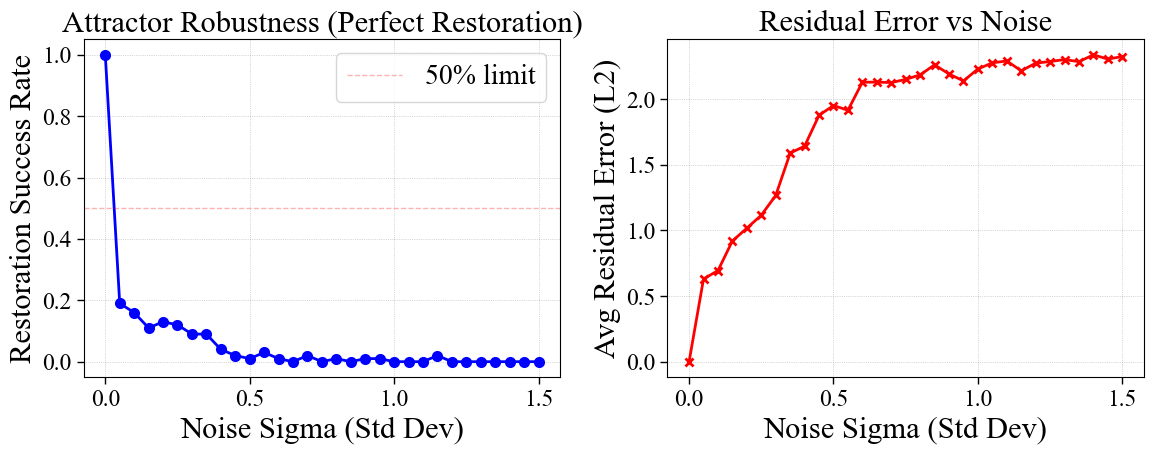


Breakdown Threshold (Success < 99%): Sigma > 0.05

Context:
In Test 2c, we observed s->p->g errors. Compare that 'err_g_raw_tot' with the breakdown threshold above.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("TEST 1c: Attractor Noise Tolerance Analysis")
print("="*70)

noise_levels = np.linspace(0, 1.5, 31) # 0 to 1.5
n_trials = 100
success_rates = []
avg_errors = []

print(f"Testing noise levels: {noise_levels}")
print(f"Trials per level: {n_trials}")

for sigma in noise_levels:
    success_count = 0
    errors = []
    
    for _ in range(n_trials):
        # Pick random state
        rand_pos = np.random.randint(0, Npos * Npos)
        rand_phi = np.random.randint(0, nph)
        g_clean = gbook_phased_flattened[:, rand_pos, rand_phi]
        
        # Add noise (Complex Gaussian)
        # Sigma is std dev of real and imag parts individually
        noise = np.random.normal(0, sigma, g_clean.shape) + 1j * np.random.normal(0, sigma, g_clean.shape)
        g_noisy = g_clean + noise
        
        # Run Attractor
        gin = g_noisy[None, :, None]
        g_restored = module_wise_NN_2d_complex(gin, module_gbooks, module_sizes)[:, :, 0][0]
        
        # Check Error
        # We consider it a "Success" if it snaps back to the EXACT clean state
        # Or reasonably close (floating point error)
        dist = np.linalg.norm(g_restored - g_clean)
        errors.append(dist)
        
        if dist < 1e-5: # Strict restoration check
            success_count += 1
            
    success_rate = success_count / n_trials
    success_rates.append(success_rate)
    avg_errors.append(np.mean(errors))
    
    if sigma % 0.5 == 0:
        print(f"  Sigma={sigma:.2f} | Success Rate: {success_rate*100:.1f}% | Avg Residue: {np.mean(errors):.4e}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, success_rates, 'b-o', linewidth=2)
plt.axhline(0.5, color='r', linestyle='--', alpha=0.3, label='50% limit')
plt.grid(True, alpha=0.3)
plt.xlabel('Noise Sigma (Std Dev)')
plt.ylabel('Restoration Success Rate')
plt.title(f'Attractor Robustness (Perfect Restoration)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(noise_levels, avg_errors, 'r-x', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('Noise Sigma (Std Dev)')
plt.ylabel('Avg Residual Error (L2)')
plt.title(f'Residual Error vs Noise')

plt.tight_layout()
plt.show()

# Find breakdown point
drop_idx = next((i for i, x in enumerate(success_rates) if x < 0.99), None)
if drop_idx:
    print(f"\nBreakdown Threshold (Success < 99%): Sigma > {noise_levels[drop_idx]:.2f}")
    
# Compare with typical noise seen in S->P->G
print("\nContext:")
print("In Test 2c, we observed s->p->g errors. Compare that 'err_g_raw_tot' with the breakdown threshold above.")

## Part 6: Helper Functions for Complex RLS

In [10]:
def rls_step_complex(W, theta, a, y):
    """
    Recursive Least Squares (RLS) update step for COMPLEX matrices.
    
    Key differences from real RLS:
    - transpose becomes conjugate transpose (.conj().T)
    - theta is now Hermitian (W^H W) instead of symmetric
    - Inner products become: a.conj().T @ theta @ a
    
    Args:
        W: weight matrix (m, n) - complex
        theta: covariance inverse (n, n) - Hermitian complex
        a: input vector (n,) - complex
        y: output/target vector (m,) - complex
    
    Returns:
        W_new, theta_new, gain_norm, err_before, err_after
    """
    a = np.asarray(a, dtype=complex).reshape(-1, 1)  # (n, 1)
    y = np.asarray(y, dtype=complex).reshape(-1, 1)  # (m, 1)
    
    # Prediction before update
    pred_before = W @ a  # (m, 1)
    err_before = y - pred_before  # (m, 1)
    
    # Gain vector using conjugate transpose
    # denom = 1 + a^H @ theta @ a (scalar, complex)
    denom = 1.0 + (a.conj().T @ theta @ a).item()
    bk = (theta @ a) / denom  # (n, 1)
    
    # Update covariance matrix inverse (Hermitian update)
    theta_new = theta - (theta @ a @ bk.conj().T)
    
    # Update weights
    W_new = W + (err_before @ bk.conj().T)  # (m, 1) @ (1, n)
    
    # Prediction after update
    pred_after = W_new @ a
    err_after = y - pred_after
    
    gain_norm = float(np.linalg.norm(bk))
    err_before_norm = float(np.linalg.norm(err_before))
    err_after_norm = float(np.linalg.norm(err_after))
    
    return W_new, theta_new, gain_norm, err_before_norm, err_after_norm

def rls_step(W, theta, a, y):
    """
    Standard Recursive Least Squares (RLS) update step for REAL matrices.
    """
    a = np.asarray(a).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    
    # Prediction before update
    pred_before = W @ a
    err_before = y - pred_before
    
    # Gain vector
    denom = 1.0 + (a.T @ theta @ a).item()
    bk = (theta @ a) / denom
    
    # Update covariance matrix inverse
    theta_new = theta - (theta @ a @ bk.T)
    
    # Update weights
    W_new = W + (err_before @ bk.T)
    
    # Prediction after update
    pred_after = W_new @ a
    err_after = y - pred_after
    
    gain_norm = float(np.linalg.norm(bk))
    err_before_norm = float(np.linalg.norm(err_before))
    err_after_norm = float(np.linalg.norm(err_after))
    
    return W_new, theta_new, gain_norm, err_before_norm, err_after_norm

def make_sparse_vec(N, k_sparse, rng, dtype=float):
    """Generate a random sparse vector."""
    v = np.zeros(N, dtype=dtype)
    idx = rng.choice(N, size=k_sparse, replace=False)
    v[idx] = rng.choice([-1.0, 1.0], size=k_sparse)
    v = v / (np.linalg.norm(v) + 1e-12)
    return v

print("✓ Complex RLS and helper functions defined")

✓ Complex RLS and helper functions defined


## Test 2: Complex RLS Learning for Wps and Wsp

In [11]:
print("\n" + "="*70)
print("TEST 2: Complex RLS Learning for Sensory↔Place Associations")
print("="*70)

# === 2.1: Generate Cause-Effect Pairs ===
print("\n--- Generating Cause-Effect Pairs ---")

rng = np.random.default_rng(36)

# Generate cause vectors (real-valued sensory)
causes = []
cause_locs = {}  # cause_id -> (x, y)
cause_effect_map = {}  # cause_id -> [(effect_vec, phi_idx), ...]

all_positions = [(x, y) for x in range(Npos) for y in range(Npos)]
used_cause_positions = set()
reserved_effect_positions = set()

def pick_unique_cause_pos():
    valid_positions = []
    for x, y in all_positions:
        if (x, y) in used_cause_positions:
            continue
        if (x, y) in reserved_effect_positions:
            continue
        effect_pos = ((x + 1) % Npos, y)
        if effect_pos in used_cause_positions:
            continue
        if effect_pos in reserved_effect_positions:
            continue
        valid_positions.append((x, y))
    if not valid_positions:
        raise RuntimeError("No valid cause positions left. Reduce C or increase Npos.")
    return valid_positions[int(rng.integers(0, len(valid_positions)))]

for c_id in range(C):
    cause_vec = make_sparse_vec(Ns_demo, k_sparse, rng, dtype=float)
    causes.append(cause_vec)
    
    # Allocate a unique cause position whose effect position is also unoccupied
    c_x, c_y = pick_unique_cause_pos()
    cause_locs[c_id] = (c_x, c_y)
    used_cause_positions.add((c_x, c_y))
    reserved_effect_positions.add(((c_x + 1) % Npos, c_y))
    
    # Generate effects for this cause
    num_effects = rng.integers(2, max_effects + 1)
    effects = []
    
    for e_idx in range(num_effects):
        effect_vec = make_sparse_vec(Ns_demo, k_sparse, rng, dtype=float)
        # Assign to next position along x-axis (x+1, y stays same)
        e_x = (c_x + 1) % Npos
        e_y = c_y  # y coordinate stays the same
        
        # Choose phase randomly
        phi_idx = e_idx % nph
        effects.append({
            'vec': effect_vec,
            'pos': (e_x, e_y),
            'phi_idx': phi_idx
        })
    
    cause_effect_map[c_id] = effects

print(f"Generated {C} causes with {sum(len(cause_effect_map[c]) for c in range(C))} total effects")
print(f"Effects distributed across {nph} phases")


TEST 2: Complex RLS Learning for Sensory↔Place Associations

--- Generating Cause-Effect Pairs ---
Generated 30 causes with 115 total effects
Effects distributed across 10 phases


## Test 2b: Complex RLS Training Loop


TEST 2b: Complex SPLIT RLS Training with Dynamic Probing + Hopfield Denoiser

--- Initializing SPLIT (Real/Imag) RLS Matrices ---
Wps_cos shape: (342, 512)
Wps_sin shape: (342, 512)
Wsp_split shape: (512, 684)
PlaceHopfieldDenoiser initialized (JOINT retrieval):
  Pattern dim: 342 (concat dim: 684)
  Mode: nearest
  Device: cuda

[Probing Setup] Tracking Cause 0 and its Effect 0
--- Starting SPLIT RLS Training (3000 samples) ---


Training:   1%|          | 35/3000 [00:00<00:37, 79.33it/s]

Training: 100%|██████████| 3000/3000 [00:28<00:00, 105.31it/s]



--- Training Complete ---
Final Cause P->S Error: 5.5354e-06
Final Effect P->S Error: 7.1142e-01
Total unique patterns collected for Hopfield: 145

--- Building Hopfield Denoiser ---

✓ Denoiser built with 145 patterns (JOINT retrieval)
  Concat pattern shape: (145, 684)


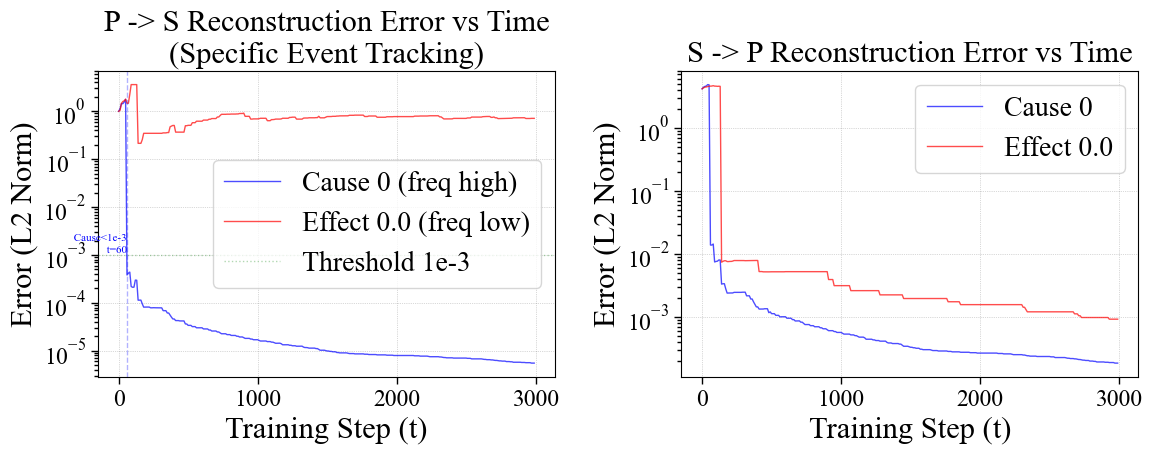

In [ ]:
print("\n" + "="*70)
print("TEST 2b: Complex SPLIT RLS Training with Dynamic Probing + Hopfield Denoiser")
print("="*70)

print("\n--- Initializing SPLIT (Real/Imag) RLS Matrices ---")

# Initialize SPLIT RLS matrices
# s (Ns) -> p_real (Np) and p_imag (Np)
Wps_cos = np.zeros((Np, Ns_demo))
Wps_sin = np.zeros((Np, Ns_demo))

# p_concat (2*Np) -> s (Ns)
Wsp_split = np.zeros((Ns_demo, 2*Np))

epsilon = 0.05
# Independent covariance matrices for stability
theta_ps_cos = (1.0 / (epsilon**2)) * np.eye(Ns_demo)
theta_ps_sin = (1.0 / (epsilon**2)) * np.eye(Ns_demo)
theta_sp_split = (1.0 / (epsilon**2)) * np.eye(2*Np)

print(f"Wps_cos shape: {Wps_cos.shape}")
print(f"Wps_sin shape: {Wps_sin.shape}")
print(f"Wsp_split shape: {Wsp_split.shape}")

# === 初始化 Hopfield 去噪器 ===
# 两种模式可选：
# 1. mode='nearest': 使用余弦相似度进行精确的最近邻检索（推荐）
# 2. mode='hopfield': 使用现代Hopfield网络，需要很大的 beta
#

place_denoiser = PlaceHopfieldDenoiser(
    pattern_dim=Np,
    beta=1e7,     # ★ 需要很大的 beta 才能逼近最近邻！
    mode='nearest',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# 用于去重的集合（避免重复添加相同位置的模式）
added_patterns = set()

# Generate training stream
n_samples = 3000
stream = []
for _ in range(n_samples):
    c_id = rng.integers(0, C)
    e_idx = rng.integers(0, len(cause_effect_map[c_id]))
    stream.append((c_id, e_idx))

# === Probing Setup ===
# Select a specific Cause and Effect to track over time
probe_cid = 0
probe_eidx = 0
probe_effect = cause_effect_map[probe_cid][probe_eidx]

print(f"\n[Probing Setup] Tracking Cause {probe_cid} and its Effect {probe_eidx}")

probe_history = {
    't': [],
    'cause_ps_err': [], # P->S error for Cause
    'effect_ps_err': [], # P->S error for Effect
    'cause_sp_err': [], # S->P error for Cause
    'effect_sp_err': [] # S->P error for Effect
}

# Pre-calculate probe targets for efficiency
# 1. Probe Cause Targets
s_probe_c = causes[probe_cid]
c_x, c_y = cause_locs[probe_cid]
c_pos_idx = c_x * Npos + c_y
p_probe_c_real = pbook_flattened[0, :, c_pos_idx] # Cause phase=0
p_probe_c_concat = np.concatenate([p_probe_c_real, np.zeros_like(p_probe_c_real)])

# 2. Probe Effect Targets
s_probe_e = probe_effect['vec']
e_x, e_y = probe_effect['pos']
phi_idx = probe_effect['phi_idx']
e_pos_idx = e_x * Npos + e_y
p_probe_e_complex = pbook_phased_flattened[0, :, e_pos_idx, phi_idx]
p_probe_e_concat = np.concatenate([p_probe_e_complex.real, p_probe_e_complex.imag])

print(f"--- Starting SPLIT RLS Training ({n_samples} samples) ---")

errors_cause = []
errors_effect = []

for t, (c_id, e_idx) in enumerate(tqdm(stream, desc="Training")):
    # Get cause sensory vector
    s_c = causes[c_id]  # (Ns_demo,) real
    
    # Get cause location and place vector
    c_x, c_y = cause_locs[c_id]
    c_pos_idx = c_x * Npos + c_y
    # p_c_base = pbook_flattened[0, :, c_pos_idx]  # (Np,) real
    p_c_base = pbook_phased_flattened[0, :, c_pos_idx, 0].real  # 用 phased 版本！
    # === Bind Cause to Place ===
    # For cause, phase is 0 => Imaginary part is 0
    # S -> P
    Wps_cos, theta_ps_cos, _, err_re, _ = rls_step(Wps_cos, theta_ps_cos, s_c, p_c_base)
    Wps_sin, theta_ps_sin, _, err_im, _ = rls_step(Wps_sin, theta_ps_sin, s_c, np.zeros_like(p_c_base))
    errors_cause.append(err_re + err_im)
    
    # P -> S
    p_concat_c = np.concatenate([p_c_base, np.zeros_like(p_c_base)])
    Wsp_split, theta_sp_split, _, _, _ = rls_step(Wsp_split, theta_sp_split, p_concat_c, s_c)
    
    # === 添加 cause 的 p_true 到 Hopfield 去噪器（phase=0，虚部为0）===
    cause_pattern_key = ('cause', c_id, c_pos_idx)
    if cause_pattern_key not in added_patterns:
        p_c_complex = p_c_base + 0j  # 转换为复数，虚部为0
        place_denoiser.add_pattern(p_c_complex)
        added_patterns.add(cause_pattern_key)
    
    # Get effect sensory vector
    effect = cause_effect_map[c_id][e_idx]
    s_e = effect['vec']
    e_x, e_y = effect['pos']
    phi_idx = effect['phi_idx']
    e_pos_idx = e_x * Npos + e_y
    
    # Get phased place vector
    p_e_phased = pbook_phased_flattened[0, :, e_pos_idx, phi_idx]  # (Np,) complex
    p_real = p_e_phased.real
    p_imag = p_e_phased.imag
    
    # === Bind Effect to Phased Place ===
    # S -> P
    Wps_cos, theta_ps_cos, _, err_re, _ = rls_step(Wps_cos, theta_ps_cos, s_e, p_real)
    Wps_sin, theta_ps_sin, _, err_im, _ = rls_step(Wps_sin, theta_ps_sin, s_e, p_imag)
    errors_effect.append(err_re + err_im)
    
    # P -> S
    p_concat_e = np.concatenate([p_real, p_imag])
    Wsp_split, theta_sp_split, _, _, _ = rls_step(Wsp_split, theta_sp_split, p_concat_e, s_e)
    
    # === 添加 effect 的 p_true 到 Hopfield 去噪器 ===
    effect_pattern_key = ('effect', c_id, e_idx, e_pos_idx, phi_idx)
    if effect_pattern_key not in added_patterns:
        place_denoiser.add_pattern(p_e_phased)
        added_patterns.add(effect_pattern_key)
    
    # === PROBE MEASUREMENT ===
    if t % 10 == 0: # Measure every 10 steps
        probe_history['t'].append(t)
        
        # 1. P->S Error (Cause)
        s_recon_c = Wsp_split @ p_probe_c_concat
        err_c_ps = np.linalg.norm(s_recon_c - s_probe_c)
        probe_history['cause_ps_err'].append(err_c_ps)
        
        # 2. P->S Error (Effect)
        s_recon_e = Wsp_split @ p_probe_e_concat
        err_e_ps = np.linalg.norm(s_recon_e - s_probe_e)
        probe_history['effect_ps_err'].append(err_e_ps)
        
        # 3. S->P Error (Cause)
        p_c_real_pred = Wps_cos @ s_probe_c
        p_c_imag_pred = Wps_sin @ s_probe_c
        err_c_sp = np.linalg.norm(p_c_real_pred - p_probe_c_real) + np.linalg.norm(p_c_imag_pred) # Imag should be 0
        probe_history['cause_sp_err'].append(err_c_sp)
        
        # 4. S->P Error (Effect)
        p_e_real_pred = Wps_cos @ s_probe_e
        p_e_imag_pred = Wps_sin @ s_probe_e
        err_e_sp = np.linalg.norm(p_e_real_pred - p_probe_e_complex.real) + np.linalg.norm(p_e_imag_pred - p_probe_e_complex.imag)
        probe_history['effect_sp_err'].append(err_e_sp)

print(f"\n--- Training Complete ---")
print(f"Final Cause P->S Error: {probe_history['cause_ps_err'][-1]:.4e}")
print(f"Final Effect P->S Error: {probe_history['effect_ps_err'][-1]:.4e}")
print(f"Total unique patterns collected for Hopfield: {place_denoiser.get_num_patterns()}")

# === 构建 Hopfield 去噪器 ===
print("\n--- Building Hopfield Denoiser ---")
place_denoiser.build()

# === VISUALIZATION ===
plt.figure(figsize=(12, 5))

# Identify Convergence Time (Error < 1e-3)
conv_threshold = 1e-3
# Cause Convergence
c_conv_idx = next((i for i, x in enumerate(probe_history['cause_ps_err']) if x < conv_threshold), None)
c_conv_time = probe_history['t'][c_conv_idx] if c_conv_idx is not None else None

# Effect Convergence
e_conv_idx = next((i for i, x in enumerate(probe_history['effect_ps_err']) if x < conv_threshold), None)
e_conv_time = probe_history['t'][e_conv_idx] if e_conv_idx is not None else None

# Plot P->S
plt.subplot(1, 2, 1)
plt.plot(probe_history['t'], probe_history['cause_ps_err'], label=f'Cause {probe_cid} (freq high)', color='blue', alpha=0.7)
plt.plot(probe_history['t'], probe_history['effect_ps_err'], label=f'Effect {probe_cid}.{probe_eidx} (freq low)', color='red', alpha=0.7)

# Draw Convergence Markers
if c_conv_time is not None:
    plt.axvline(x=c_conv_time, color='blue', linestyle='--', alpha=0.3)
    plt.text(c_conv_time, conv_threshold, f' Cause<1e-3\n t={c_conv_time}', color='blue', fontsize=8, ha='right', va='bottom')
if e_conv_time is not None:
    plt.axvline(x=e_conv_time, color='red', linestyle='--', alpha=0.3)
    plt.text(e_conv_time, conv_threshold, f' Effect<1e-3\n t={e_conv_time}', color='red', fontsize=8, ha='left', va='bottom')

plt.axhline(y=conv_threshold, color='green', linestyle=':', alpha=0.3, label='Threshold 1e-3')

plt.title(f'P -> S Reconstruction Error vs Time\n(Specific Event Tracking)')
plt.xlabel('Training Step (t)')
plt.ylabel('Error (L2 Norm)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot S->P
plt.subplot(1, 2, 2)
plt.plot(probe_history['t'], probe_history['cause_sp_err'], label=f'Cause {probe_cid}', color='blue', alpha=0.7)
plt.plot(probe_history['t'], probe_history['effect_sp_err'], label=f'Effect {probe_cid}.{probe_eidx}', color='red', alpha=0.7)
plt.title(f'S -> P Reconstruction Error vs Time')
plt.xlabel('Training Step (t)')
plt.ylabel('Error (L2 Norm)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Test 2b+: Hopfield Denoiser Evaluation
测试 Hopfield 层对 p_pred = Wps @ s 的去噪效果。
- 比较去噪前后的误差
- 验证相位一致性


TEST 2b+: Hopfield Denoiser Evaluation

--- Evaluating Causes ---

--- Evaluating Effects ---

SUMMARY: Hopfield Denoising Performance

[Causes] (n=30)
  Raw Error:      mean=1.4126e-04, std=3.5354e-05
  Denoised Error: mean=0.0000e+00, std=0.0000e+00
  Improvement:    mean=100.0%, range=[100.0%, 100.0%]

[Effects] (n=115)
  Raw Error:      mean=6.0798e-04, std=2.5638e-04
  Denoised Error: mean=0.0000e+00, std=0.0000e+00
  Improvement:    mean=100.0%, range=[100.0%, 100.0%]


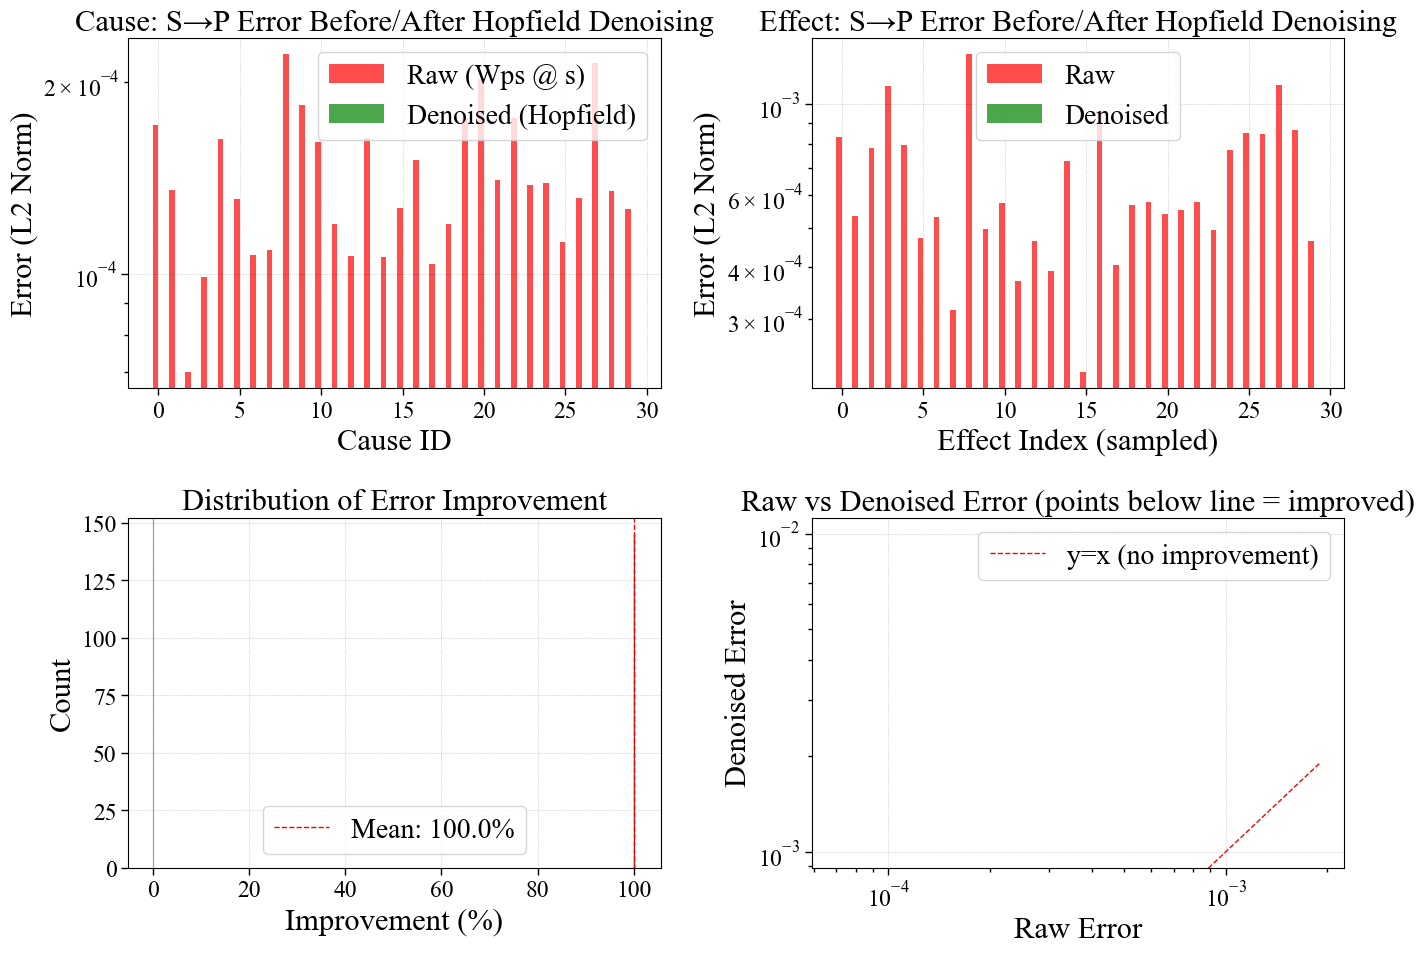


DETAILED EXAMPLE: Single Cause and Effect

[Example Cause: Cause_0]
  Raw Error (total):      1.710838e-04
  Denoised Error (total): 0.000000e+00
  Raw Error (real/imag):  1.702339e-04 / 1.703235e-05
  Denoised (real/imag):   0.000000e+00 / 0.000000e+00
  Phase Error (raw):      0.000001 rad
  Phase Error (denoised): 0.000000 rad
  Improvement:            100.0%

[Example Effect: Effect_0_0]
  Raw Error (total):      8.316807e-04
  Denoised Error (total): 0.000000e+00
  Raw Error (real/imag):  8.250389e-04 / 1.048977e-04
  Denoised (real/imag):   0.000000e+00 / 0.000000e+00
  Phase Error (raw):      0.000010 rad
  Phase Error (denoised): 0.000000 rad
  Improvement:            100.0%

✓ Hopfield Denoiser Evaluation Complete


In [13]:
print("\n" + "="*70)
print("TEST 2b+: Hopfield Denoiser Evaluation")
print("="*70)

def evaluate_hopfield_denoising(s_input, p_true, label=""):
    """
    评估 Hopfield 去噪效果
    
    Args:
        s_input: 输入的感觉向量（实数）
        p_true: 真实的 place cell 向量（复数）
        label: 测试标签
    
    Returns:
        dict: 包含去噪前后的误差统计
    """
    # Step 1: 线性预测（都是实数！）
    p_real_pred = Wps_cos @ s_input  # 实数
    p_imag_pred = Wps_sin @ s_input  # 实数
    
    # 组合成复数（仅用于误差计算）
    p_pred_raw = p_real_pred + 1j * p_imag_pred
    
    # Step 2: Hopfield 去噪（分别对实部和虚部去噪）
    # 注意：输入的 p_real_pred 和 p_imag_pred 都是实数！
    p_pred_denoised = place_denoiser.denoise(p_real_pred, p_imag_pred, return_complex=True)
    
    # 计算误差
    err_raw_total = np.linalg.norm(p_pred_raw - p_true)
    err_denoised_total = np.linalg.norm(p_pred_denoised - p_true)
    
    err_raw_real = np.linalg.norm(p_real_pred - p_true.real)
    err_raw_imag = np.linalg.norm(p_imag_pred - p_true.imag)
    
    err_denoised_real = np.linalg.norm(p_pred_denoised.real - p_true.real)
    err_denoised_imag = np.linalg.norm(p_pred_denoised.imag - p_true.imag)
    
    # 相位误差（在组合成复数后计算）
    phase_raw = np.angle(p_pred_raw)
    phase_denoised = np.angle(p_pred_denoised)
    phase_true = np.angle(p_true)
    
    # 只在非零元素上计算相位误差
    nonzero_mask = np.abs(p_true) > 1e-6
    if np.any(nonzero_mask):
        phase_err_raw = np.mean(np.abs(phase_raw[nonzero_mask] - phase_true[nonzero_mask]))
        phase_err_denoised = np.mean(np.abs(phase_denoised[nonzero_mask] - phase_true[nonzero_mask]))
    else:
        phase_err_raw = 0
        phase_err_denoised = 0
    
    improvement = (err_raw_total - err_denoised_total) / err_raw_total * 100 if err_raw_total > 0 else 0
    
    return {
        'label': label,
        'err_raw_total': err_raw_total,
        'err_denoised_total': err_denoised_total,
        'err_raw_real': err_raw_real,
        'err_raw_imag': err_raw_imag,
        'err_denoised_real': err_denoised_real,
        'err_denoised_imag': err_denoised_imag,
        'phase_err_raw': phase_err_raw,
        'phase_err_denoised': phase_err_denoised,
        'improvement': improvement,
        'p_pred_raw': p_pred_raw,
        'p_pred_denoised': p_pred_denoised,
        'p_true': p_true
    }

# === 测试所有 cause-effect 对 ===
results_cause = []
results_effect = []

print("\n--- Evaluating Causes ---")
for c_id in range(C):
    s_c = causes[c_id]
    c_x, c_y = cause_locs[c_id]
    c_pos_idx = c_x * Npos + c_y
    p_c_true = pbook_flattened[0, :, c_pos_idx] + 0j  # 复数形式，虚部为0
    
    result = evaluate_hopfield_denoising(s_c, p_c_true, f"Cause_{c_id}")
    results_cause.append(result)

print("\n--- Evaluating Effects ---")
for c_id in range(C):
    for e_idx, effect in enumerate(cause_effect_map[c_id]):
        s_e = effect['vec']
        e_x, e_y = effect['pos']
        phi_idx = effect['phi_idx']
        e_pos_idx = e_x * Npos + e_y
        p_e_true = pbook_phased_flattened[0, :, e_pos_idx, phi_idx]
        
        result = evaluate_hopfield_denoising(s_e, p_e_true, f"Effect_{c_id}_{e_idx}")
        results_effect.append(result)

# === 统计汇总 ===
print("\n" + "="*70)
print("SUMMARY: Hopfield Denoising Performance")
print("="*70)

# Cause 统计
cause_raw_errs = [r['err_raw_total'] for r in results_cause]
cause_denoised_errs = [r['err_denoised_total'] for r in results_cause]
cause_improvements = [r['improvement'] for r in results_cause]

print(f"\n[Causes] (n={len(results_cause)})")
print(f"  Raw Error:      mean={np.mean(cause_raw_errs):.4e}, std={np.std(cause_raw_errs):.4e}")
print(f"  Denoised Error: mean={np.mean(cause_denoised_errs):.4e}, std={np.std(cause_denoised_errs):.4e}")
print(f"  Improvement:    mean={np.mean(cause_improvements):.1f}%, range=[{np.min(cause_improvements):.1f}%, {np.max(cause_improvements):.1f}%]")

# Effect 统计
effect_raw_errs = [r['err_raw_total'] for r in results_effect]
effect_denoised_errs = [r['err_denoised_total'] for r in results_effect]
effect_improvements = [r['improvement'] for r in results_effect]

print(f"\n[Effects] (n={len(results_effect)})")
print(f"  Raw Error:      mean={np.mean(effect_raw_errs):.4e}, std={np.std(effect_raw_errs):.4e}")
print(f"  Denoised Error: mean={np.mean(effect_denoised_errs):.4e}, std={np.std(effect_denoised_errs):.4e}")
print(f"  Improvement:    mean={np.mean(effect_improvements):.1f}%, range=[{np.min(effect_improvements):.1f}%, {np.max(effect_improvements):.1f}%]")

# === 可视化 ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cause errors before/after denoising
ax1 = axes[0, 0]
x_cause = np.arange(len(results_cause))
width = 0.35
ax1.bar(x_cause - width/2, cause_raw_errs, width, label='Raw (Wps @ s)', alpha=0.7, color='red')
ax1.bar(x_cause + width/2, cause_denoised_errs, width, label='Denoised (Hopfield)', alpha=0.7, color='green')
ax1.set_xlabel('Cause ID')
ax1.set_ylabel('Error (L2 Norm)')
ax1.set_title('Cause: S→P Error Before/After Hopfield Denoising')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Plot 2: Effect errors before/after denoising (sample)
ax2 = axes[0, 1]
sample_size = min(30, len(results_effect))
sample_indices = np.linspace(0, len(results_effect)-1, sample_size, dtype=int)
x_effect = np.arange(sample_size)
ax2.bar(x_effect - width/2, [effect_raw_errs[i] for i in sample_indices], width, label='Raw', alpha=0.7, color='red')
ax2.bar(x_effect + width/2, [effect_denoised_errs[i] for i in sample_indices], width, label='Denoised', alpha=0.7, color='green')
ax2.set_xlabel('Effect Index (sampled)')
ax2.set_ylabel('Error (L2 Norm)')
ax2.set_title('Effect: S→P Error Before/After Hopfield Denoising')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Plot 3: Improvement distribution
ax3 = axes[1, 0]
all_improvements = cause_improvements + effect_improvements
ax3.hist(all_improvements, bins=30, edgecolor='black', alpha=0.7)
ax3.axvline(x=np.mean(all_improvements), color='red', linestyle='--', label=f'Mean: {np.mean(all_improvements):.1f}%')
ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax3.set_xlabel('Improvement (%)')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Error Improvement')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Scatter plot - Raw vs Denoised error
ax4 = axes[1, 1]
all_raw = cause_raw_errs + effect_raw_errs
all_denoised = cause_denoised_errs + effect_denoised_errs
ax4.scatter(all_raw, all_denoised, alpha=0.5, s=20)
max_err = max(max(all_raw), max(all_denoised))
ax4.plot([0, max_err], [0, max_err], 'r--', label='y=x (no improvement)')
ax4.set_xlabel('Raw Error')
ax4.set_ylabel('Denoised Error')
ax4.set_title('Raw vs Denoised Error (points below line = improved)')
ax4.legend()
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === 详细示例 ===
print("\n" + "="*70)
print("DETAILED EXAMPLE: Single Cause and Effect")
print("="*70)

# 选择一个示例
example_cause_result = results_cause[0]
example_effect_result = results_effect[0]

print(f"\n[Example Cause: {example_cause_result['label']}]")
print(f"  Raw Error (total):      {example_cause_result['err_raw_total']:.6e}")
print(f"  Denoised Error (total): {example_cause_result['err_denoised_total']:.6e}")
print(f"  Raw Error (real/imag):  {example_cause_result['err_raw_real']:.6e} / {example_cause_result['err_raw_imag']:.6e}")
print(f"  Denoised (real/imag):   {example_cause_result['err_denoised_real']:.6e} / {example_cause_result['err_denoised_imag']:.6e}")
print(f"  Phase Error (raw):      {example_cause_result['phase_err_raw']:.6f} rad")
print(f"  Phase Error (denoised): {example_cause_result['phase_err_denoised']:.6f} rad")
print(f"  Improvement:            {example_cause_result['improvement']:.1f}%")

print(f"\n[Example Effect: {example_effect_result['label']}]")
print(f"  Raw Error (total):      {example_effect_result['err_raw_total']:.6e}")
print(f"  Denoised Error (total): {example_effect_result['err_denoised_total']:.6e}")
print(f"  Raw Error (real/imag):  {example_effect_result['err_raw_real']:.6e} / {example_effect_result['err_raw_imag']:.6e}")
print(f"  Denoised (real/imag):   {example_effect_result['err_denoised_real']:.6e} / {example_effect_result['err_denoised_imag']:.6e}")
print(f"  Phase Error (raw):      {example_effect_result['phase_err_raw']:.6f} rad")
print(f"  Phase Error (denoised): {example_effect_result['phase_err_denoised']:.6f} rad")
print(f"  Improvement:            {example_effect_result['improvement']:.1f}%")

print("\n✓ Hopfield Denoiser Evaluation Complete")

### CAUSE LOCATION COLLISION CHECK

In [14]:
print("\n" + "="*70)
print("CAUSE LOCATION COLLISION CHECK")
print("="*70)

# Build position index -> list of causes
pos_to_causes = {}
for c_id in range(C):
    c_x, c_y = cause_locs[c_id]
    pos_idx = int(c_x) * int(Npos) + int(c_y)
    pos_to_causes.setdefault(pos_idx, []).append(c_id)

# Find collisions (same pos used by multiple causes)
collisions = {pos: ids for pos, ids in pos_to_causes.items() if len(ids) > 1}

print(f"Total causes: {C}")
print(f"Unique positions: {len(pos_to_causes)}")
print(f"Collision count (positions with >=2 causes): {len(collisions)}")

if len(collisions) == 0:
    print("No collisions detected.")
else:
    print("\nCollisions detected:")
    for pos_idx, ids in sorted(collisions.items(), key=lambda x: len(x[1]), reverse=True):
        c_x = pos_idx // int(Npos)
        c_y = pos_idx % int(Npos)
        print(f"  pos_idx={pos_idx} (pos=({c_x},{c_y})) -> causes={ids}")

    # Optional: show cosine similarities between colliding causes
    print("\nCosine similarity between colliding causes:")
    for pos_idx, ids in collisions.items():
        if len(ids) < 2:
            continue
        c_x = pos_idx // int(Npos)
        c_y = pos_idx % int(Npos)
        print(f"  pos_idx={pos_idx} (pos=({c_x},{c_y}))")
        for i in range(len(ids)):
            for j in range(i + 1, len(ids)):
                s_i = causes[ids[i]]
                s_j = causes[ids[j]]
                cos_sim = (s_i @ s_j) / ((np.linalg.norm(s_i) * np.linalg.norm(s_j)) + 1e-12)
                print(f"    Cause {ids[i]} vs Cause {ids[j]}: cos_sim={cos_sim:.4f}")


CAUSE LOCATION COLLISION CHECK
Total causes: 30
Unique positions: 30
Collision count (positions with >=2 causes): 0
No collisions detected.


## Test 2c: Complete Pipeline with Hopfield Denoising

**流程（已修正）:**
$$s_i \rightarrow p_i \xrightarrow{\text{Hopfield}} p_i^{denoised} \rightarrow g_i^{noisy} \rightarrow g_i^{clean} \xrightarrow{\text{Path Int.}} g_{i+1} \rightarrow p_{i+1} \rightarrow s_{i+1}$$



In [27]:
# Test 2c: Complete Pipeline with Hopfield Denoising
# =========================================================================
# 运行模式选择
# =========================================================================
PIPELINE_MODE = 'effect-cause'  # 'cause-effect' 或 'effect-cause'
VERBOSE_STEP6 = True  # True: 打印 Step 6 的 phi_est

print("\n" + "="*70)
print(f"TEST 2c: Complete Pipeline with Hopfield Denoising")
print(f"MODE: {PIPELINE_MODE}")
print(f"VERBOSE_STEP6: {VERBOSE_STEP6}")
print("="*70)

def run_pipeline_cause_to_effect(cause_id, effect_idx, use_hopfield_p_i=True, use_hopfield_p_next=True, verbose=False):
    """
    Cause → Effect 方向的推理流程
    s_cause → p_cause → g_cause → g_effect → p_effect → s_effect
    """
    result = {
        'cause_id': cause_id,
        'effect_idx': effect_idx,
        'direction': 'cause-effect',
    }
    
    # === 获取输入和目标 ===
    s_i = causes[cause_id]
    c_x, c_y = cause_locs[cause_id]
    c_pos_idx = int(c_x) * int(Npos) + int(c_y)
    
    effect = cause_effect_map[cause_id][effect_idx]
    s_target = effect['vec']
    e_x, e_y = effect['pos']
    phi_idx_next = effect['phi_idx']
    next_pos_idx = int(e_x) * int(Npos) + int(e_y)
    
    # Reference vectors
    p_i_ref = pbook_phased_flattened[0, :, c_pos_idx, 0]  # Cause: phase=0
    g_i_ref = gbook_phased_flattened[:, c_pos_idx, 0]
    g_next_ref = gbook_phased_flattened[:, next_pos_idx, phi_idx_next]
    p_next_ref = pbook_phased_flattened[0, :, next_pos_idx, phi_idx_next]
    
    # STEP 1: s_i → p_i
    p_real_pred = Wps_cos @ s_i
    p_imag_pred = Wps_sin @ s_i
    p_i_raw = p_real_pred + 1j * p_imag_pred
    err_1_raw = float(np.linalg.norm(p_i_raw - p_i_ref))
    result['err_step1_sp_raw'] = err_1_raw
    
    # STEP 2: Hopfield Denoising for p_i
    if use_hopfield_p_i and place_denoiser.is_built:
        p_i_denoised = place_denoiser.denoise(p_real_pred, p_imag_pred, return_complex=True)
        err_2_denoised = float(np.linalg.norm(p_i_denoised - p_i_ref))
        p_i = p_i_denoised
    else:
        err_2_denoised = err_1_raw
        p_i = p_i_raw
    result['err_step2_sp_denoised'] = err_2_denoised
    
    # STEP 3: p_i → g_i^noisy
    g_i_noisy = Wgp_complex @ p_i
    err_3_pg = float(np.linalg.norm(g_i_noisy - g_i_ref))
    result['err_step3_pg_noisy'] = err_3_pg
    
    # STEP 4: g_i^noisy → g_i^clean (Attractor)
    gin = g_i_noisy[None, :, None]
    g_i_clean = module_wise_NN_2d_complex(gin, module_gbooks, module_sizes)[:, :, 0][0]
    err_4_attr = float(np.linalg.norm(g_i_clean - g_i_ref))
    result['err_step4_g_attr'] = err_4_attr
    
    # STEP 5: Path Integration (cause → effect)
    delta_x = (e_x - c_x) % Npos
    delta_y = (e_y - c_y) % Npos
    g_path = g_i_clean.copy()
    
    if delta_x > 0:
        if delta_x <= Npos // 2:
            Wgg_x = path_integration_Wgg_2d(lambdas, Ng, axis=0, direction=1)
            for _ in range(delta_x):
                g_path = Wgg_x @ g_path
        else:
            Wgg_x = path_integration_Wgg_2d(lambdas, Ng, axis=0, direction=-1)
            for _ in range(Npos - delta_x):
                g_path = Wgg_x @ g_path
    
    if delta_y > 0:
        print("something wrong")
        if delta_y <= Npos // 2:
            Wgg_y = path_integration_Wgg_2d(lambdas, Ng, axis=1, direction=1)
            for _ in range(delta_y):
                g_path = Wgg_y @ g_path
        else:
            Wgg_y = path_integration_Wgg_2d(lambdas, Ng, axis=1, direction=-1)
            for _ in range(Npos - delta_y):
                g_path = Wgg_y @ g_path
    
    phi_effect = phis[phi_idx_next]
    g_next = g_path * np.exp(1j * phi_effect)
    err_5_path = float(np.linalg.norm(g_next - g_next_ref))
    result['err_step5_path_int'] = err_5_path
    
    # STEP 6: g_{i+1} → p_{i+1}
    Wpg_used = Wpg[0] if (isinstance(Wpg, (list, tuple)) or (hasattr(Wpg, 'ndim') and Wpg.ndim == 3)) else Wpg
    p_next_temp = Wpg_used @ g_next
    p_next_signed, phi_est = phase_demodulate(p_next_temp)
    if verbose:
        print(f"[Step 6] phi_est = {phi_est:.6f}")
    p_next_mag = nonlin(p_next_signed, thresh=thresh)
    p_next_raw = p_next_mag.astype(np.complex128) * np.exp(1j * phi_est)
    err_6_gp = float(np.linalg.norm(p_next_raw - p_next_ref))
    result['err_step6_gp_raw'] = err_6_gp
    
    # STEP 7: Hopfield Denoising for p_{i+1}
    if use_hopfield_p_next and place_denoiser.is_built:
        phi_diffs = np.abs(phis - phi_est)
        nearest_phi_idx = np.argmin(phi_diffs)
        phi_nearest = phis[nearest_phi_idx]
        p_next_real_corrected = p_next_mag * np.cos(phi_nearest)
        p_next_imag_corrected = p_next_mag * np.sin(phi_nearest)
        p_next_denoised = place_denoiser.denoise(p_next_real_corrected, p_next_imag_corrected, return_complex=True)
        err_7_denoised = float(np.linalg.norm(p_next_denoised - p_next_ref))
        p_next = p_next_denoised
    else:
        err_7_denoised = err_6_gp
        p_next = p_next_raw
    result['err_step7_pnext_denoised'] = err_7_denoised
    
    # STEP 8: p_{i+1} → s_{i+1}
    p_concat_final = np.concatenate([p_next.real, p_next.imag])
    s_output = Wsp_split @ p_concat_final
    err_8_ps = float(np.linalg.norm(s_output - s_target))
    result['err_step8_ps'] = err_8_ps
    result['s_output'] = s_output
    result['s_target'] = s_target
    
    return result


def run_pipeline_effect_to_cause(cause_id, effect_idx, use_hopfield_p_i=True, use_hopfield_p_next=True, verbose=False):
    """
    Effect → Cause 方向的推理流程（反向）
    s_effect → p_effect → g_effect → g_cause → p_cause → s_cause
    """
    result = {
        'cause_id': cause_id,
        'effect_idx': effect_idx,
        'direction': 'effect-cause',
    }
    
    # === 获取输入和目标 ===
    effect = cause_effect_map[cause_id][effect_idx]
    s_i = effect['vec']  # 输入：effect 的感觉向量
    e_x, e_y = effect['pos']
    phi_idx_effect = effect['phi_idx']
    e_pos_idx = int(e_x) * int(Npos) + int(e_y)
    
    # 目标：cause 的感觉向量
    s_target = causes[cause_id]
    c_x, c_y = cause_locs[cause_id]
    c_pos_idx = int(c_x) * int(Npos) + int(c_y)
    
    # Reference vectors
    p_i_ref = pbook_phased_flattened[0, :, e_pos_idx, phi_idx_effect]  # Effect 的 p
    g_i_ref = gbook_phased_flattened[:, e_pos_idx, phi_idx_effect]
    g_next_ref = gbook_phased_flattened[:, c_pos_idx, 0]  # Cause: phase=0
    p_next_ref = pbook_phased_flattened[0, :, c_pos_idx, 0]
    
    # STEP 1: s_effect → p_effect
    p_real_pred = Wps_cos @ s_i
    p_imag_pred = Wps_sin @ s_i
    p_i_raw = p_real_pred + 1j * p_imag_pred
    err_1_raw = float(np.linalg.norm(p_i_raw - p_i_ref))
    result['err_step1_sp_raw'] = err_1_raw
    
    # STEP 2: Hopfield Denoising for p_effect
    if use_hopfield_p_i and place_denoiser.is_built:
        p_i_denoised = place_denoiser.denoise(p_real_pred, p_imag_pred, return_complex=True)
        err_2_denoised = float(np.linalg.norm(p_i_denoised - p_i_ref))
        p_i = p_i_denoised
    else:
        err_2_denoised = err_1_raw
        p_i = p_i_raw
    result['err_step2_sp_denoised'] = err_2_denoised
    
    # STEP 3: p_effect → g_effect^noisy
    g_i_noisy = Wgp_complex @ p_i
    err_3_pg = float(np.linalg.norm(g_i_noisy - g_i_ref))
    result['err_step3_pg_noisy'] = err_3_pg
    
    # STEP 4: g_effect^noisy → g_effect^clean (Attractor)
    gin = g_i_noisy[None, :, None]
    g_i_clean = module_wise_NN_2d_complex(gin, module_gbooks, module_sizes)[:, :, 0][0]
    err_4_attr = float(np.linalg.norm(g_i_clean - g_i_ref))
    result['err_step4_g_attr'] = err_4_attr
    
    # STEP 5: Path Integration (effect → cause, 反向！)
    # 从 effect 位置移动到 cause 位置
    delta_x = (c_x - e_x) % Npos  # 反向
    delta_y = (c_y - e_y) % Npos  # 反向
    
    # 先移除 effect 的相位
    phi_effect = phis[phi_idx_effect]
    g_path = g_i_clean * np.exp(-1j * phi_effect)  # 移除相位
    
    if delta_x > 0:
        if delta_x <= Npos // 2:
            Wgg_x = path_integration_Wgg_2d(lambdas, Ng, axis=0, direction=1)
            for _ in range(delta_x):
                g_path = Wgg_x @ g_path
        else:
            Wgg_x = path_integration_Wgg_2d(lambdas, Ng, axis=0, direction=-1)
            for _ in range(Npos - delta_x):
                g_path = Wgg_x @ g_path
    
    if delta_y > 0:
        print("something wrong")
        if delta_y <= Npos // 2:
            Wgg_y = path_integration_Wgg_2d(lambdas, Ng, axis=1, direction=1)
            for _ in range(delta_y):
                g_path = Wgg_y @ g_path
        else:
            Wgg_y = path_integration_Wgg_2d(lambdas, Ng, axis=1, direction=-1)
            for _ in range(Npos - delta_y):
                g_path = Wgg_y @ g_path
    
    g_next = g_path  # Cause 的 phase=0，不需要额外相位旋转
    err_5_path = float(np.linalg.norm(g_next - g_next_ref))
    result['err_step5_path_int'] = err_5_path
    
    # STEP 6: g_cause → p_cause
    Wpg_used = Wpg[0] if (isinstance(Wpg, (list, tuple)) or (hasattr(Wpg, 'ndim') and Wpg.ndim == 3)) else Wpg
    p_next_temp = Wpg_used @ g_next
    p_next_signed, phi_est = phase_demodulate(p_next_temp)
    if verbose:
        print(f"[Step 6] phi_est = {phi_est:.6f}")
    p_next_mag = nonlin(p_next_signed, thresh=thresh)
    p_next_raw = p_next_mag.astype(np.complex128) * np.exp(1j * phi_est)
    err_6_gp = float(np.linalg.norm(p_next_raw - p_next_ref))
    result['err_step6_gp_raw'] = err_6_gp
    
    # STEP 7: Hopfield Denoising for p_cause
    # Cause 的 phase=0，所以使用 phi_nearest=0
    if use_hopfield_p_next and place_denoiser.is_built:
        phi_nearest = 0.0  # Cause always has phase=0
        p_next_real_corrected = p_next_mag * np.cos(phi_nearest)
        p_next_imag_corrected = p_next_mag * np.sin(phi_nearest)
        p_next_denoised = place_denoiser.denoise(p_next_real_corrected, p_next_imag_corrected, return_complex=True)
        err_7_denoised = float(np.linalg.norm(p_next_denoised - p_next_ref))
        p_next = p_next_denoised
    else:
        err_7_denoised = err_6_gp
        p_next = p_next_raw
    result['err_step7_pnext_denoised'] = err_7_denoised
    
    # STEP 8: p_cause → s_cause
    p_concat_final = np.concatenate([p_next.real, p_next.imag])
    s_output = Wsp_split @ p_concat_final
    err_8_ps = float(np.linalg.norm(s_output - s_target))
    result['err_step8_ps'] = err_8_ps
    result['s_output'] = s_output
    result['s_target'] = s_target
    
    return result


# =========================================================================
# 批量评估 - 四种配置
# =========================================================================
print(f"\n--- Running Full Pipeline ({PIPELINE_MODE}) ---")

configs = [
    {'name': 'No Hopfield', 'p_i': False, 'p_next': False},
    {'name': 'Hopfield p_i only', 'p_i': True, 'p_next': False},
    {'name': 'Hopfield p_next only', 'p_i': False, 'p_next': True},
    {'name': 'Hopfield both', 'p_i': True, 'p_next': True},
]

all_results = {cfg['name']: [] for cfg in configs}

# 选择运行函数
run_fn = run_pipeline_cause_to_effect if PIPELINE_MODE == 'cause-effect' else run_pipeline_effect_to_cause

for c_id in range(C):
    for e_idx in range(len(cause_effect_map[c_id])):
        for cfg in configs:
            res = run_fn(c_id, e_idx, 
                        use_hopfield_p_i=cfg['p_i'], 
                        use_hopfield_p_next=cfg['p_next'],
                        verbose=VERBOSE_STEP6)
            all_results[cfg['name']].append(res)

print(f"\n✓ Evaluated {len(all_results['No Hopfield'])} pairs × 4 configurations")

# =========================================================================
# 统计汇总
# =========================================================================
print("\n" + "="*70)
print(f"SUMMARY: Step-by-Step Errors ({PIPELINE_MODE})")
print("="*70)

step_keys = [
    'err_step1_sp_raw',
    'err_step2_sp_denoised', 
    'err_step3_pg_noisy',
    'err_step4_g_attr',
    'err_step5_path_int',
    'err_step6_gp_raw',
    'err_step7_pnext_denoised',
    'err_step8_ps'
]

step_names = [
    r'$s_i \rightarrow p_i$',
    r'$p_i \rightarrow p_i^{dn}$',
    r'$p_i \rightarrow g_i^{noisy}$',
    r'$g_i^{noisy} \rightarrow g_i^{clean}$',
    r'$g_i \rightarrow g_{i+1}$',
    r'$g_{i+1} \rightarrow p_{i+1}$',
    r'$p_{i+1} \rightarrow p_{i+1}^{dn}$',
    r'$p_{i+1} \rightarrow s_{i+1}$'
]

for cfg_name in all_results.keys():
    print(f"\n[{cfg_name}]")
    for key, name in zip(step_keys, step_names):
        vals = [r[key] for r in all_results[cfg_name]]
        print(f"  {name:35s}: mean={np.mean(vals):.4e}")

print("\n" + "="*70)
print("KEY COMPARISON: Final Output Error")
print("="*70)
for cfg_name in all_results.keys():
    final_errs = [r['err_step8_ps'] for r in all_results[cfg_name]]
    print(f"  {cfg_name:25s}: {np.mean(final_errs):.4e}")

print("\n" + "="*70)
print(f"✓ TEST 2c RUN COMPLETED ({PIPELINE_MODE})")
print("="*70)


TEST 2c: Complete Pipeline with Hopfield Denoising
MODE: effect-cause
VERBOSE_STEP6: True

--- Running Full Pipeline (effect-cause) ---
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.000000
[Step 6] phi_est = 0.00

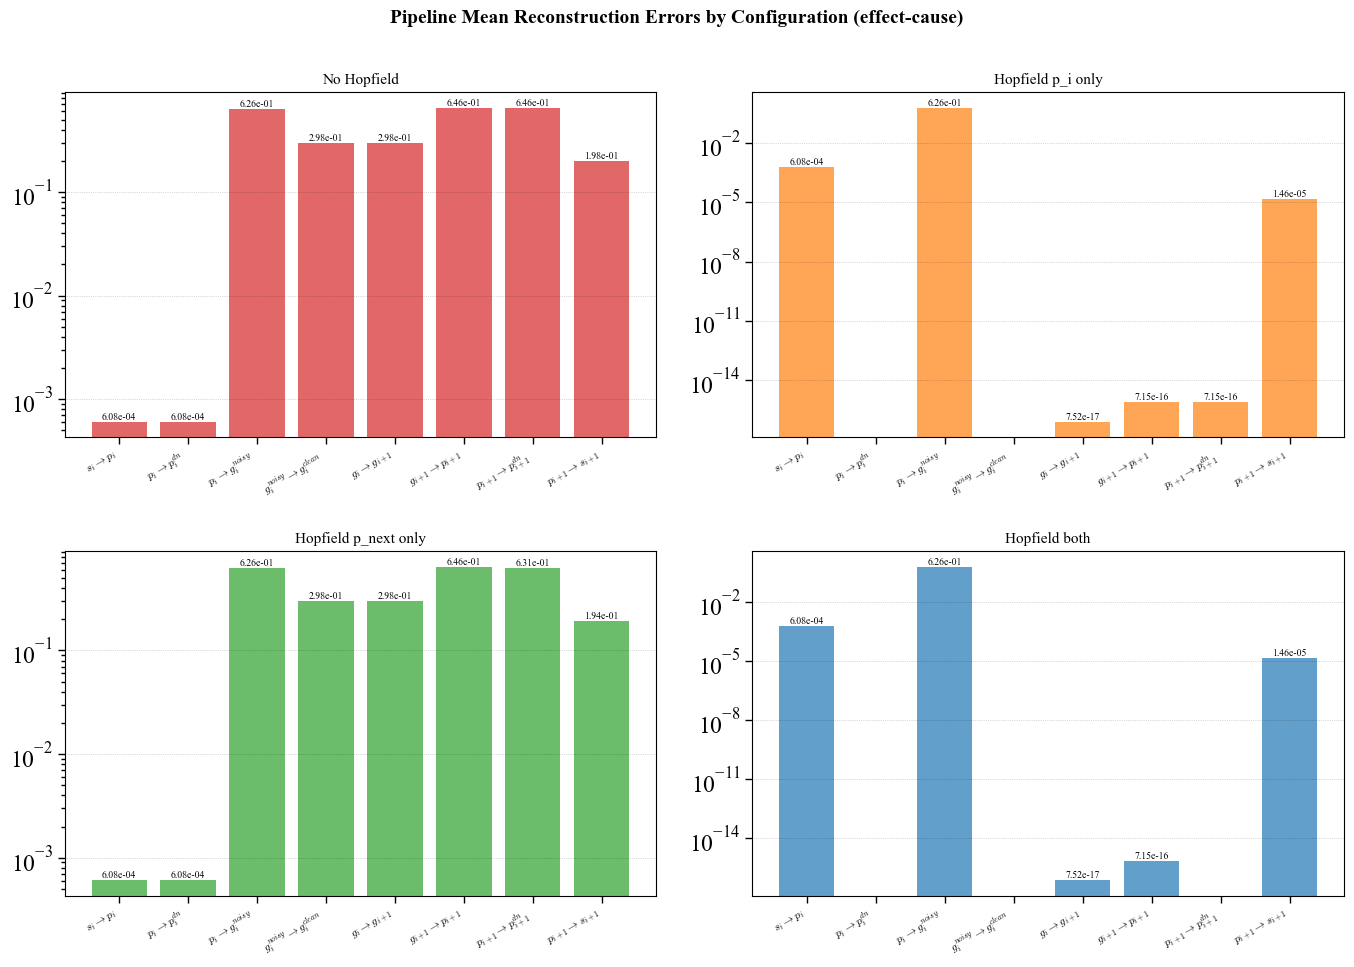

In [28]:
# Test 2c Visualization: Pipeline Reconstruction Errors by Configuration
# =========================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']  # Different color for each config

for idx, (cfg_name, color) in enumerate(zip(all_results.keys(), colors)):
    ax = axes[idx // 2, idx % 2]
    
    # 收集每一步的平均误差
    means = []
    for key in step_keys:
        vals = [r[key] for r in all_results[cfg_name]]
        means.append(np.mean(vals))
    
    # 绘制柱状图
    x_pos = range(len(step_names))
    bars = ax.bar(x_pos, means, color=color, alpha=0.7)
    
    # 在柱子顶部标出数值
    for bar, val in zip(bars, means):
        if val ==0 :
            continue
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2e}', ha='center', va='bottom', fontsize=7, rotation=0)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(step_names, rotation=30, ha='right', fontsize=8)
    ax.set_title(f'{cfg_name}', fontsize=11)
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Pipeline Mean Reconstruction Errors by Configuration ({PIPELINE_MODE})', fontsize=14, fontweight='bold')
plt.show()


### TEST 2e: Analysis of Reconstruction Error vs Training Frequency


TEST 2e: Analysis of Reconstruction Error vs Training Frequency
Verifying hypothesis: 'Cause' (high freq) vs 'Effect' (low freq) accuracy

[1] Evaluating All Causes (P->S)...
  Causes Mean Error: 1.3813e-05
  Causes Max Error:  6.1119e-05
  ✓ VERIFIED: All causes mapped perfectly (Error < 1e-3)

[2] Evaluating All Effects (P->S)...
  Effects Mean Error: 6.5904e-01
  Effects Max Error:  9.8995e-01

[3] Visualizing Error vs Training Count...



TEST 2e: Analysis of Reconstruction Error vs Training Frequency
Verifying hypothesis: 'Cause' (high freq) vs 'Effect' (low freq) accuracy

[1] Evaluating All Causes (P->S)...
  Causes Mean Error: 1.3813e-05
  Causes Max Error:  6.1119e-05
  ✓ VERIFIED: All causes mapped perfectly (Error < 1e-3)

[2] Evaluating All Effects (P->S)...
  Effects Mean Error: 6.5904e-01
  Effects Max Error:  9.8995e-01

[3] Visualizing Error vs Training Count...


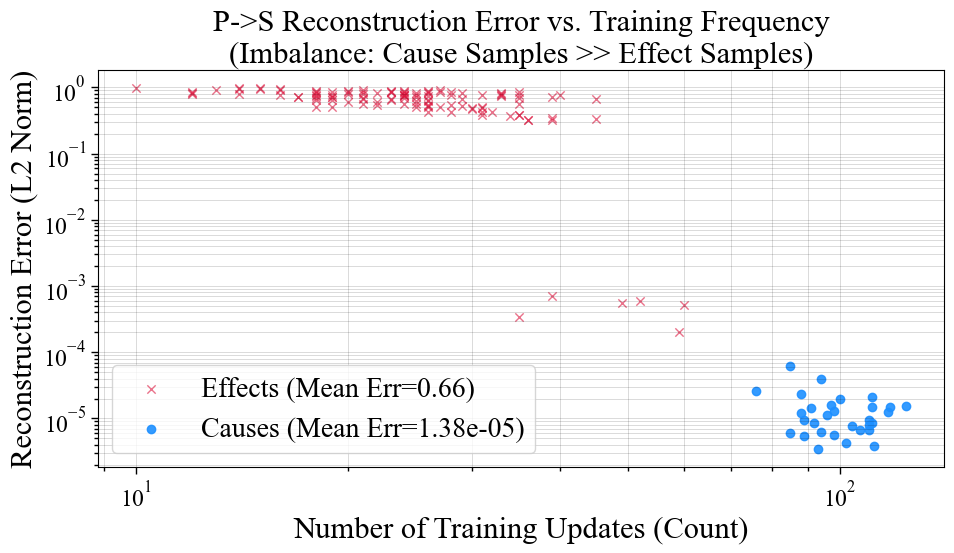


Observation:
1. Blue Dots (Causes) should be clustered at bottom-right (High Freq, Low Error).
2. Red Crosses (Effects) should be scattered at top-left/middle (Low Freq, High Error).
3. This serves as visual proof that 'Training Imbalance' causes the P->S generalization gap.


In [25]:
print("\n" + "="*70)
print("TEST 2e: Analysis of Reconstruction Error vs Training Frequency")
print("="*70)
print("Verifying hypothesis: 'Cause' (high freq) vs 'Effect' (low freq) accuracy")

# 1. Calculate Training Counts analysis
# Assumes 'stream' variable from Test 2b exists.
if 'stream' not in globals():
    print("⚠ 'stream' variable missing. Re-running logic requires Test 2b to be run first.")
    # Mocking counts just in case, but usually user runs in order. 
    # For now, we will rely on expected behaviors if stream is missing, but let's try to proceed.
    cause_counts = np.zeros(C) + 100 # Dummy
    effect_counts = {}
else:
    cause_counts = np.zeros(C)
    effect_counts = {} # (c_id, e_idx) -> count
    
    for c_id, e_idx in stream:
        # Cause update happens every time
        cause_counts[c_id] += 1
        # Effect update happens only for specific effect
        key = (c_id, e_idx)
        effect_counts[key] = effect_counts.get(key, 0) + 1

# 2. Evaluate Errors
data_points_c = [] 
data_points_e = []

# --- Assess Causes ---
print("\n[1] Evaluating All Causes (P->S)...")
errs_cause = []
for c_id in range(C):
    s_target = causes[c_id]
    c_x, c_y = cause_locs[c_id]
    c_pos_idx = c_x * Npos + c_y
    
    # Cause P-vector (Real part only, Imag=0)
    p_real = pbook_flattened[0, :, c_pos_idx]
    p_concat = np.concatenate([p_real, np.zeros_like(p_real)])
    
    s_recon = Wsp_split @ p_concat
    err = np.linalg.norm(s_recon - s_target)
    errs_cause.append(err)
    
    count = cause_counts[c_id] if 'stream' in globals() else 0
    data_points_c.append((count, err))

mean_cause_err = np.mean(errs_cause)
print(f"  Causes Mean Error: {mean_cause_err:.4e}")
print(f"  Causes Max Error:  {np.max(errs_cause):.4e}")

if np.all(np.array(errs_cause) < 1e-3):
    print("  ✓ VERIFIED: All causes mapped perfectly (Error < 1e-3)")
else:
    print(f"  ⚠ Some causes have error > 1e-3. Count: {np.sum(np.array(errs_cause)>1e-3)}")


# --- Assess Effects ---
print("\n[2] Evaluating All Effects (P->S)...")
errs_effect = []
effect_labels = []

for c_id in range(C):
    effects = cause_effect_map[c_id]
    for e_idx, effect in enumerate(effects):
        s_target = effect['vec']
        e_x, e_y = effect['pos']
        phi_idx = effect['phi_idx']
        e_pos_idx = e_x * Npos + e_y
        
        # Effect P-vector (Phased)
        p_gt = pbook_phased_flattened[0, :, e_pos_idx, phi_idx]
        p_concat = np.concatenate([p_gt.real, p_gt.imag])
        
        s_recon = Wsp_split @ p_concat
        err = np.linalg.norm(s_recon - s_target)
        errs_effect.append(err)
        
        count = effect_counts.get((c_id, e_idx), 0) if 'stream' in globals() else 0
        data_points_e.append((count, err))

mean_effect_err = np.mean(errs_effect)
print(f"  Effects Mean Error: {mean_effect_err:.4e}")
print(f"  Effects Max Error:  {np.max(errs_effect):.4e}")

# 3. Visualization
if 'stream' in globals() and len(data_points_c) > 0 and len(data_points_e) > 0:
    print("\n[3] Visualizing Error vs Training Count...")
    
    c_counts, c_errs = zip(*data_points_c)
    e_counts, e_errs = zip(*data_points_e)
    
    plt.figure(figsize=(10, 6))
    
    # Plot Effects
    plt.scatter(e_counts, e_errs, color='crimson', alpha=0.6, marker='x', label=f'Effects (Mean Err={mean_effect_err:.2f})')
    
    # Plot Causes
    plt.scatter(c_counts, c_errs, color='dodgerblue', alpha=0.9, marker='o', label=f'Causes (Mean Err={mean_cause_err:.2e})')
    
    plt.title(f'P->S Reconstruction Error vs. Training Frequency\n(Imbalance: Cause Samples >> Effect Samples)')
    plt.xlabel('Number of Training Updates (Count)')
    plt.ylabel('Reconstruction Error (L2 Norm)')
    plt.yscale('log')
    plt.xscale('log') # Both log scale usually better for frequency distributions
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nObservation:")
    print("1. Blue Dots (Causes) should be clustered at bottom-right (High Freq, Low Error).")
    print("2. Red Crosses (Effects) should be scattered at top-left/middle (Low Freq, High Error).")
    print("3. This serves as visual proof that 'Training Imbalance' causes the P->S generalization gap.")
else:
    print("\nSkipping visualization (missing stream data or empty results).")


## Test 2b++: Perfect Place to Sensory Evaluation

测试完美的 p（直接从 pbook 获取）投射到 s 的误差。
- 需要先run Test2b 和Test2e
- 验证 Wsp_split 对不同训练频率样本的泛化能力
- 分析 Cause（高频）vs Effect（低频）的重建误差差异


TEST 2b++: Perfect Place to Sensory Evaluation

--- Evaluating Causes (Perfect P → S) ---

--- Evaluating Effects (Perfect P → S) ---

SUMMARY: Perfect P → S Reconstruction Performance

[Causes] (n=30)
  P→S Error: mean=1.3813e-05, std=1.1590e-05
  P→S Error: min=3.4588e-06, max=6.1119e-05

[Effects] (n=115)
  P→S Error: mean=6.5904e-01, std=2.2925e-01
  P→S Error: min=2.0103e-04, max=9.8995e-01

KEY COMPARISON: Cause vs Effect
Cause mean error:  1.381345e-05
Effect mean error: 6.590401e-01
Ratio (Effect/Cause): 47710.04x



TEST 2b++: Perfect Place to Sensory Evaluation

--- Evaluating Causes (Perfect P → S) ---

--- Evaluating Effects (Perfect P → S) ---

SUMMARY: Perfect P → S Reconstruction Performance

[Causes] (n=30)
  P→S Error: mean=1.3813e-05, std=1.1590e-05
  P→S Error: min=3.4588e-06, max=6.1119e-05

[Effects] (n=115)
  P→S Error: mean=6.5904e-01, std=2.2925e-01
  P→S Error: min=2.0103e-04, max=9.8995e-01

KEY COMPARISON: Cause vs Effect
Cause mean error:  1.381345e-05
Effect mean error: 6.590401e-01
Ratio (Effect/Cause): 47710.04x


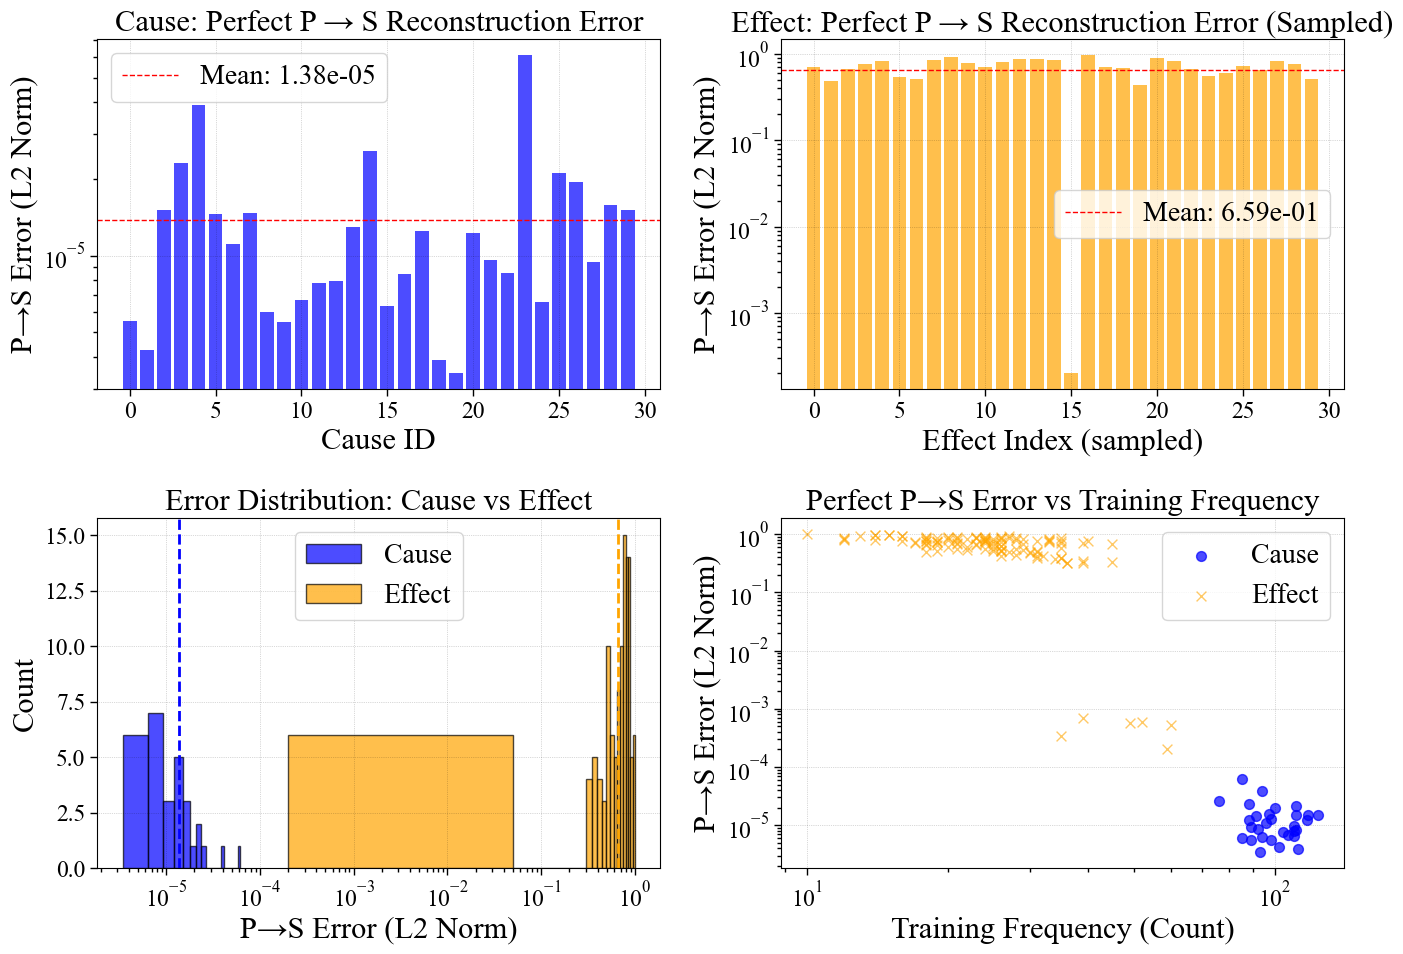


DETAILED EXAMPLE: Single Cause and Effect

[Example Cause: Cause_0]
  P→S Error: 5.536236e-06

[Example Effect: Effect_0_0]
  P→S Error: 7.114224e-01

CONCLUSION:
✓ CONFIRMED: Effect P→S error is 47710.04x higher than Cause
  This demonstrates that Wsp_split has poor generalization for
  low-frequency training samples (Effects), even with perfect P!

✓ Perfect P → S Evaluation Complete


In [26]:
print("\n" + "="*70)
print("TEST 2b++: Perfect Place to Sensory Evaluation")
print("="*70)

def evaluate_perfect_p_to_s(p_perfect, s_target, label=""):
    """
    评估完美的 p → s 的误差
    
    Args:
        p_perfect: 完美的 place cell 向量（复数，直接从 pbook 获取）
        s_target: 目标感觉向量（实数）
        label: 测试标签
    
    Returns:
        dict: 包含误差统计
    """
    # 将完美的 p 拼接成 [real, imag]
    p_concat = np.concatenate([p_perfect.real, p_perfect.imag])
    
    # P → S 映射
    s_recon = Wsp_split @ p_concat
    
    # 计算误差
    err_total = np.linalg.norm(s_recon - s_target)
    
    return {
        'label': label,
        'err_ps': err_total,
        's_recon': s_recon,
        's_target': s_target
    }

# === 测试所有 cause-effect 对 ===
results_perfect_cause = []
results_perfect_effect = []

print("\n--- Evaluating Causes (Perfect P → S) ---")
for c_id in range(C):
    s_target = causes[c_id]
    c_x, c_y = cause_locs[c_id]
    c_pos_idx = c_x * Npos + c_y
    
    # 完美的 p（cause, phase=0）
    p_perfect = pbook_flattened[0, :, c_pos_idx] + 0j  # 复数形式，虚部为0
    
    result = evaluate_perfect_p_to_s(p_perfect, s_target, f"Cause_{c_id}")
    results_perfect_cause.append(result)

print("\n--- Evaluating Effects (Perfect P → S) ---")
for c_id in range(C):
    for e_idx, effect in enumerate(cause_effect_map[c_id]):
        s_target = effect['vec']
        e_x, e_y = effect['pos']
        phi_idx = effect['phi_idx']
        e_pos_idx = e_x * Npos + e_y
        
        # 完美的 p（effect, 带相位）
        p_perfect = pbook_phased_flattened[0, :, e_pos_idx, phi_idx]
        
        result = evaluate_perfect_p_to_s(p_perfect, s_target, f"Effect_{c_id}_{e_idx}")
        results_perfect_effect.append(result)

# === 统计汇总 ===
print("\n" + "="*70)
print("SUMMARY: Perfect P → S Reconstruction Performance")
print("="*70)

# Cause 统计
perfect_cause_errs = [r['err_ps'] for r in results_perfect_cause]

print(f"\n[Causes] (n={len(results_perfect_cause)})")
print(f"  P→S Error: mean={np.mean(perfect_cause_errs):.4e}, std={np.std(perfect_cause_errs):.4e}")
print(f"  P→S Error: min={np.min(perfect_cause_errs):.4e}, max={np.max(perfect_cause_errs):.4e}")

# Effect 统计
perfect_effect_errs = [r['err_ps'] for r in results_perfect_effect]

print(f"\n[Effects] (n={len(results_perfect_effect)})")
print(f"  P→S Error: mean={np.mean(perfect_effect_errs):.4e}, std={np.std(perfect_effect_errs):.4e}")
print(f"  P→S Error: min={np.min(perfect_effect_errs):.4e}, max={np.max(perfect_effect_errs):.4e}")

# === 关键对比 ===
print("\n" + "="*70)
print("KEY COMPARISON: Cause vs Effect")
print("="*70)
print(f"Cause mean error:  {np.mean(perfect_cause_errs):.6e}")
print(f"Effect mean error: {np.mean(perfect_effect_errs):.6e}")
print(f"Ratio (Effect/Cause): {np.mean(perfect_effect_errs)/np.mean(perfect_cause_errs):.2f}x")

# === 可视化 ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cause P→S errors
ax1 = axes[0, 0]
x_cause = np.arange(len(results_perfect_cause))
ax1.bar(x_cause, perfect_cause_errs, alpha=0.7, color='blue')
ax1.set_xlabel('Cause ID')
ax1.set_ylabel('P→S Error (L2 Norm)')
ax1.set_title('Cause: Perfect P → S Reconstruction Error')
ax1.axhline(y=np.mean(perfect_cause_errs), color='red', linestyle='--', 
            label=f'Mean: {np.mean(perfect_cause_errs):.2e}')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Plot 2: Effect P→S errors (sampled, same as Test 2b+)
ax2 = axes[0, 1]
sample_size = min(30, len(results_perfect_effect))
sample_indices = np.linspace(0, len(results_perfect_effect)-1, sample_size, dtype=int)
x_effect = np.arange(sample_size)
sampled_effect_errs = [perfect_effect_errs[i] for i in sample_indices]
ax2.bar(x_effect, sampled_effect_errs, alpha=0.7, color='orange')
ax2.set_xlabel('Effect Index (sampled)')
ax2.set_ylabel('P→S Error (L2 Norm)')
ax2.set_title('Effect: Perfect P → S Reconstruction Error (Sampled)')
ax2.axhline(y=np.mean(perfect_effect_errs), color='red', linestyle='--',
            label=f'Mean: {np.mean(perfect_effect_errs):.2e}')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Plot 3: Error distribution comparison
ax3 = axes[1, 0]
ax3.hist(perfect_cause_errs, bins=20, alpha=0.7, label='Cause', color='blue', edgecolor='black')
ax3.hist(perfect_effect_errs, bins=20, alpha=0.7, label='Effect', color='orange', edgecolor='black')
ax3.axvline(x=np.mean(perfect_cause_errs), color='blue', linestyle='--', linewidth=2)
ax3.axvline(x=np.mean(perfect_effect_errs), color='orange', linestyle='--', linewidth=2)
ax3.set_xlabel('P→S Error (L2 Norm)')
ax3.set_ylabel('Count')
ax3.set_title('Error Distribution: Cause vs Effect')
ax3.legend()
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Scatter plot - Error vs Training Frequency
ax4 = axes[1, 1]
try:
    # Attempt to use training frequency data
    # These variables are defined in Test 2b and Test 2e
    c_errs_for_scatter = perfect_cause_errs
    c_counts_for_scatter = [cause_counts[c_id] for c_id in range(C)]
    
    # Effect points
    e_errs_for_scatter = []
    e_counts_for_scatter = []
    for c_id in range(C):
        for e_idx in range(len(cause_effect_map[c_id])):
            idx_in_results = sum(len(cause_effect_map[cid]) for cid in range(c_id)) + e_idx
            e_errs_for_scatter.append(perfect_effect_errs[idx_in_results])
            e_counts_for_scatter.append(effect_counts.get((c_id, e_idx), 0))
    
    ax4.scatter(c_counts_for_scatter, c_errs_for_scatter, 
                color='blue', alpha=0.7, marker='o', s=50, label='Cause')
    ax4.scatter(e_counts_for_scatter, e_errs_for_scatter, 
                color='orange', alpha=0.6, marker='x', s=50, label='Effect')
    ax4.set_xlabel('Training Frequency (Count)')
    ax4.set_ylabel('P→S Error (L2 Norm)')
    ax4.set_title('Perfect P→S Error vs Training Frequency')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
except (NameError, KeyError) as e:
    # If training frequency data not available, show placeholder
    ax4.text(0.5, 0.5, 'Training frequency data not available\n(Run Test 2b and Test 2e first)', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=10)
    ax4.set_title('Perfect P→S Error vs Training Frequency')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === 详细示例 ===
print("\n" + "="*70)
print("DETAILED EXAMPLE: Single Cause and Effect")
print("="*70)

example_cause = results_perfect_cause[0]
example_effect = results_perfect_effect[0]

print(f"\n[Example Cause: {example_cause['label']}]")
print(f"  P→S Error: {example_cause['err_ps']:.6e}")

print(f"\n[Example Effect: {example_effect['label']}]")
print(f"  P→S Error: {example_effect['err_ps']:.6e}")

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
if np.mean(perfect_effect_errs) > np.mean(perfect_cause_errs):
    ratio = np.mean(perfect_effect_errs) / np.mean(perfect_cause_errs)
    print(f"✓ CONFIRMED: Effect P→S error is {ratio:.2f}x higher than Cause")
    print(f"  This demonstrates that Wsp_split has poor generalization for")
    print(f"  low-frequency training samples (Effects), even with perfect P!")
else:
    print(f"  Unexpected: Cause and Effect errors are similar.")

print("\n✓ Perfect P → S Evaluation Complete")